In [1]:
import numpy as np

# Trees - A continuation

The story so far: we've computed a represetation of trees as products of terms in a polynomial ring of (countably) infinitely many noncommuting variables. $x_0$, $x_1$, $x_2$, ... where each subscript denotes the level of the tree at which it occurs. Variables can appear twice in a product, but will represent different nodes each time they occur. It is possible to remove this ambiguity by indexing differently (e.g. by sequences of $L$'s and $R$'s denoting the path from the root), but this is unnecessary (and gets ugly very quickly). The key that makes this representation work is that nodes only connect directly up generations or directly down generations, never across the same generation (there's no communication between siblings that isn't through an ancestor), so a separate $x_2$ will never be ambiguously specified by its immediate neighbors.

Toward the goal of exploring the possible trees, let's use some free algebras here in Sage:

In [62]:
names = ['x%d' %i for i in range(10)]

In [433]:
F = FreeAlgebra(QQ, names=['x%d' % i for i in range(10)] + ['z'], implementation='letterplace')

In [434]:
u, v = F.gens()[:-1], F.gens()[-1]

In [435]:
u, v

((x0, x1, x2, x3, x4, x5, x6, x7, x8, x9), z)

This creates a free algebra on 10 variables and an extra variable $z$. We purposely assign them to, however, some different variable names, for what follows. What we'll do now is create the relation that $z$ commutes with everything. It should be significant that $z$ was created last: the algebra is always standardized so that earlier variables in the above definition should appear in product earlier than later ones; the relations should be keyed on things that _don't_ follow this convention. So we specify $z$ first to be the commutation.

In [150]:
commutations = [
    v*u[d] - u[d]*v
    for d in range(10)
]

In [151]:
commutations

[-x0*z + z*x0,
 -x1*z + z*x1,
 -x2*z + z*x2,
 -x3*z + z*x3,
 -x4*z + z*x4,
 -x5*z + z*x5,
 -x6*z + z*x6,
 -x7*z + z*x7,
 -x8*z + z*x8,
 -x9*z + z*x9]

In [152]:
T = F.quotient(F*commutations*F)
T

Quotient of Free Associative Unital Algebra on 11 generators (x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, z) over Rational Field by the ideal (-x0*z + z*x0, -x1*z + z*x1, -x2*z + z*x2, -x3*z + z*x3, -x4*z + z*x4, -x5*z + z*x5, -x6*z + z*x6, -x7*z + z*x7, -x8*z + z*x8, -x9*z + z*x9)

x1

_Now_ we call the Python variables $x$ and $z$; this obeys the commutation rules.

In [153]:
x, z = T.gens()[:-1], T.gens()[-1]
x, z

((x0bar, x1bar, x2bar, x3bar, x4bar, x5bar, x6bar, x7bar, x8bar, x9bar), zbar)

Let's check that it works.

In [162]:
z*x[9]*z*x[8]*z*x[1]*z*x[8]*z*x[8]

zbar*zbar*zbar*zbar*zbar*x9bar*x8bar*x1bar*x8bar*x8bar

In [163]:
x[8]*x[1]*z*x[1]

zbar*x8bar*x1bar*x1bar

In [164]:
-x[1]*z + z*x[1]

0

In [165]:
T.zero()

0

In [166]:
(v*u[1]*v).reduce(commutations)


z*z*x1

Not 100% what we want; it doesn't seem to collapse into exponents (I would think this is legal, because the algebra is associative, but *sigh*). We manually parse the string and do replacements.

In [175]:
generating_string = '1 + T*u[0]*T'

In [176]:
generating_string = generating_string.replace('T', '(1 + T*u[1]*T)')

In [177]:
generating_string = generating_string.replace('T', '(1 + T*u[2]*T)')

In [178]:
generating_string = generating_string.replace('T', '(1 + T*u[3]*T)')

In [179]:
generating_string = generating_string.replace('T', '1')

In [180]:
generating_string

'1 + (1 + (1 + (1 + 1*u[3]*1)*u[2]*(1 + 1*u[3]*1))*u[1]*(1 + (1 + 1*u[3]*1)*u[2]*(1 + 1*u[3]*1)))*u[0]*(1 + (1 + (1 + 1*u[3]*1)*u[2]*(1 + 1*u[3]*1))*u[1]*(1 + (1 + 1*u[3]*1)*u[2]*(1 + 1*u[3]*1)))'

In [181]:
eval(generating_string)

ArithmeticError: Can only add elements of the same weighted degree

Ugh, these CAS's are not as capable as I think they should be. It appears that terms of different degrees cannot be added. That is certainly strange, since free algebras are about permitting random strings of product of terms. Oh well. Let's just do some manual hackery. We'll learn more this way anyway. Let's parse the strings they generate for $z$'s and manually kill off the ones at a higher level than we want.

In [1081]:
F = FreeAlgebra(QQ, names=['x%d' % i for i in range(10)] + ['z'] )

In [1082]:
x, z = F.gens()[:-1], F.gens()[-1]

This crude "rewriter" will expand the tree expression, replacing `T` with $x$ at a higher level each time. Then it evaluates it using the distributive law,

In [340]:
type(x[0])

<class 'sage.algebras.free_algebra.FreeAlgebra_generic_with_category.element_class'>

In [407]:
def get_tree_string(level):
    gen_string = '1 + T*x[0]*z*T'
    for i in range(0, level):
        # substitute T with the next level of recursion, but using an x from a higher degree
        gen_string = gen_string.replace('T', '(1 + T*x[{}]*z*T)'.format(i+1))
    expr = eval(gen_string.replace('T', '0'))
    terms = [t for t, _ in list(expr)]
    new_terms = []
    for term in terms:
        # brute force commute all the z's to the end
        factors = list(term)
        z_factors = [f for f, _ in factors if f == z]
        x_factors = [f for f, _ in factors if f != z]
        if len(z_factors) > level: continue
        new_term = prod(x_factors + z_factors)
        # for some reason, new_term is cast to monoid rather than algebra so we have to reinterpret as string and back
        new_term = str(new_term)
        for j in range(10):
            new_term = new_term.replace('x%d' % j, 'x[%d]' % j)
        new_terms.append(new_term.replace('^', '**'))
    return eval('+'.join(new_terms))

In [417]:
[get_tree_string(i) for i in range(3)]

[1, 1 + x0*z, 1 + x0*z + x0*x1*z^2 + x1*x0*z^2]

Get to 3 levels of the tree.

In [418]:
three_levels = get_tree_string(3)

In [429]:
pretty_print(three_levels)

1 + x0*z + x0*x1*z^2 + x1*x0*z^2 + x0*x1*x2*z^3 + x0*x2*x1*z^3 + x1*x0*x1*z^3 + x1*x2*x0*z^3 + x2*x1*x0*z^3

To interpret this, given a variable that you see, find the closest adjacent (either one above or one below), and connect it in the direction that is in the order of the product. E.g. for $x_0 x_2 x_1$, start with the $x_0$ at level $0$, connected it down and to the right to $x_1$. Now given $x_2$ connect it _up_ and to the right to $x_1$. Finally, with $x_1$, we would connect it up and to the left to $x_0$ but it's already been connected that way from working with $x_0$ (but you can draw it twice as a sanity check). Note that $x_1 x_0 x_1$ has $x_1$ appearing twice. This is because in this case there are two nodes on level $1$, connect $x_1$ to $x_0$ with an upper right, and connect $x_0$ to the next $x_1$ with a lower right.

Now if we substitute $1$ for all the variables, we should get the Catalan number $c_k$ as the coefficient of $z^k$:

In [424]:
three_levels.subs({x[0]:1, x[1]:1, x[2]:1})

1 + z + 2*z^2 + 5*z^3

Similarly, for $4$ levels:

In [414]:
expr = get_tree_string(4)

In [415]:
expr.subs({x[d]: 1 for d in range(10)})

1 + z + 2*z^2 + 5*z^3 + 14*z^4

In [430]:
pretty_print(expr)

1 + x0*z + x0*x1*z^2 + x1*x0*z^2 + x0*x1*x2*z^3 + x0*x2*x1*z^3 + x1*x0*x1*z^3 + x1*x2*x0*z^3 + x2*x1*x0*z^3 + x0*x1*x2*x3*z^4 + x0*x1*x3*x2*z^4 + x0*x2*x1*x2*z^4 + x0*x2*x3*x1*z^4 + x0*x3*x2*x1*z^4 + x1*x0*x1*x2*z^4 + x1*x0*x2*x1*z^4 + x1*x2*x0*x1*z^4 + x1*x2*x3*x0*z^4 + x1*x3*x2*x0*z^4 + x2*x1*x0*x1*z^4 + x2*x1*x2*x0*z^4 + x2*x3*x1*x0*z^4 + x3*x2*x1*x0*z^4

This takes several minutes: lots of terms blow up, as well as our filtering procedure being pretty crude:

In [416]:
yy = get_tree_string(5)

In [431]:
pretty_print(yy)

1 + x0*z + x0*x1*z^2 + x1*x0*z^2 + x0*x1*x2*z^3 + x0*x2*x1*z^3 + x1*x0*x1*z^3 + x1*x2*x0*z^3 + x2*x1*x0*z^3 + x0*x1*x2*x3*z^4 + x0*x1*x3*x2*z^4 + x0*x2*x1*x2*z^4 + x0*x2*x3*x1*z^4 + x0*x3*x2*x1*z^4 + x1*x0*x1*x2*z^4 + x1*x0*x2*x1*z^4 + x1*x2*x0*x1*z^4 + x1*x2*x3*x0*z^4 + x1*x3*x2*x0*z^4 + x2*x1*x0*x1*z^4 + x2*x1*x2*x0*z^4 + x2*x3*x1*x0*z^4 + x3*x2*x1*x0*z^4 + x0*x1*x2*x3*x4*z^5 + x0*x1*x2*x4*x3*z^5 + x0*x1*x3*x2*x3*z^5 + x0*x1*x3*x4*x2*z^5 + x0*x1*x4*x3*x2*z^5 + x0*x2*x1*x2*x3*z^5 + x0*x2*x1*x3*x2*z^5 + x0*x2*x3*x1*x2*z^5 + x0*x2*x3*x4*x1*z^5 + x0*x2*x4*x3*x1*z^5 + x0*x3*x2*x1*x2*z^5 + x0*x3*x2*x3*x1*z^5 + x0*x3*x4*x2*x1*z^5 + x0*x4*x3*x2*x1*z^5 + x1*x0*x1*x2*x3*z^5 + x1*x0*x1*x3*x2*z^5 + x1*x0*x2*x1*x2*z^5 + x1*x0*x2*x3*x1*z^5 + x1*x0*x3*x2*x1*z^5 + x1*x2*x0*x1*x2*z^5 + x1*x2*x0*x2*x1*z^5 + x1*x2*x3*x0*x1*z^5 + x1*x2*x3*x4*x0*z^5 + x1*x2*x4*x3*x0*z^5 + x1*x3*x2*x0*x1*z^5 + x1*x3*x2*x3*x0*z^5 + x1*x3*x4*x2*x0*z^5 + x1*x4*x3*x2*x0*z^5 + x2*x1*x0*x1*x2*z^5 + x2*x1*x0*x2*x1*z^5 + x2*x1*x2*x0*x1*z^5 + x2*x1*x2*x3*x0*z^5 + x2*x1*x3*x2*x0*z^5 + x2*x3*x1*x0*x1*z^5 + x2*x3*x1*x2*x0*z^5 + x2*x3*x4*x1*x0*z^5 + x2*x4*x3*x1*x0*z^5 + x3*x2*x1*x0*x1*z^5 + x3*x2*x1*x2*x0*z^5 + x3*x2*x3*x1*x0*z^5 + x3*x4*x2*x1*x0*z^5 + x4*x3*x2*x1*x0*z^5

It does deliver the correct $42$ for $c_5$, though!

In [421]:
yy.subs({x[d]: 1 for d in range(10)})

1 + z + 2*z^2 + 5*z^3 + 14*z^4 + 42*z^5

We also can get rid of the $z$ any time we like by setting it to zero and letting the pure length of the term serve to distinguish it.

In [432]:
pretty_print(yy.subs({z:1}))

1 + x0 + x0*x1 + x1*x0 + x0*x1*x2 + x0*x2*x1 + x1*x0*x1 + x1*x2*x0 + x2*x1*x0 + x0*x1*x2*x3 + x0*x1*x3*x2 + x0*x2*x1*x2 + x0*x2*x3*x1 + x0*x3*x2*x1 + x1*x0*x1*x2 + x1*x0*x2*x1 + x1*x2*x0*x1 + x1*x2*x3*x0 + x1*x3*x2*x0 + x2*x1*x0*x1 + x2*x1*x2*x0 + x2*x3*x1*x0 + x3*x2*x1*x0 + x0*x1*x2*x3*x4 + x0*x1*x2*x4*x3 + x0*x1*x3*x2*x3 + x0*x1*x3*x4*x2 + x0*x1*x4*x3*x2 + x0*x2*x1*x2*x3 + x0*x2*x1*x3*x2 + x0*x2*x3*x1*x2 + x0*x2*x3*x4*x1 + x0*x2*x4*x3*x1 + x0*x3*x2*x1*x2 + x0*x3*x2*x3*x1 + x0*x3*x4*x2*x1 + x0*x4*x3*x2*x1 + x1*x0*x1*x2*x3 + x1*x0*x1*x3*x2 + x1*x0*x2*x1*x2 + x1*x0*x2*x3*x1 + x1*x0*x3*x2*x1 + x1*x2*x0*x1*x2 + x1*x2*x0*x2*x1 + x1*x2*x3*x0*x1 + x1*x2*x3*x4*x0 + x1*x2*x4*x3*x0 + x1*x3*x2*x0*x1 + x1*x3*x2*x3*x0 + x1*x3*x4*x2*x0 + x1*x4*x3*x2*x0 + x2*x1*x0*x1*x2 + x2*x1*x0*x2*x1 + x2*x1*x2*x0*x1 + x2*x1*x2*x3*x0 + x2*x1*x3*x2*x0 + x2*x3*x1*x0*x1 + x2*x3*x1*x2*x0 + x2*x3*x4*x1*x0 + x2*x4*x3*x1*x0 + x3*x2*x1*x0*x1 + x3*x2*x1*x2*x0 + x3*x2*x3*x1*x0 + x3*x4*x2*x1*x0 + x4*x3*x2*x1*x0

In [423]:
[list(y) for y, _ in list(yy)]

[[(x4, 1), (x3, 1), (x2, 1), (x1, 1), (x0, 1), (z, 5)],
 [(x3, 1), (x4, 1), (x2, 1), (x1, 1), (x0, 1), (z, 5)],
 [(x3, 1), (x2, 1), (x3, 1), (x1, 1), (x0, 1), (z, 5)],
 [(x3, 1), (x2, 1), (x1, 1), (x2, 1), (x0, 1), (z, 5)],
 [(x3, 1), (x2, 1), (x1, 1), (x0, 1), (x1, 1), (z, 5)],
 [(x3, 1), (x2, 1), (x1, 1), (x0, 1), (z, 4)],
 [(x2, 1), (x4, 1), (x3, 1), (x1, 1), (x0, 1), (z, 5)],
 [(x2, 1), (x3, 1), (x4, 1), (x1, 1), (x0, 1), (z, 5)],
 [(x2, 1), (x3, 1), (x1, 1), (x2, 1), (x0, 1), (z, 5)],
 [(x2, 1), (x3, 1), (x1, 1), (x0, 1), (x1, 1), (z, 5)],
 [(x2, 1), (x3, 1), (x1, 1), (x0, 1), (z, 4)],
 [(x2, 1), (x1, 1), (x3, 1), (x2, 1), (x0, 1), (z, 5)],
 [(x2, 1), (x1, 1), (x2, 1), (x3, 1), (x0, 1), (z, 5)],
 [(x2, 1), (x1, 1), (x2, 1), (x0, 1), (x1, 1), (z, 5)],
 [(x2, 1), (x1, 1), (x2, 1), (x0, 1), (z, 4)],
 [(x2, 1), (x1, 1), (x0, 1), (x2, 1), (x1, 1), (z, 5)],
 [(x2, 1), (x1, 1), (x0, 1), (x1, 1), (x2, 1), (z, 5)],
 [(x2, 1), (x1, 1), (x0, 1), (x1, 1), (z, 4)],
 [(x2, 1), (x1, 1), (x0, 1),

In [443]:
1000*np.log(1000) - 1000 + 0.5*np.log(1000) - 0.5*np.log(2*np.pi) -  log(factorial(1000)).n(200)

In [439]:
log(factorial(1000)).n(20)

5912.1

# It's all fun and games until someone has to actually verify concretely...

Let's implement a basic tree class. It supports recursive inserts, and some interesting counting functions such as keys and heights, and an interesting function (shape_descriptor) that essentially gives us a string representing all the indices corresponding to the noncommuting variables we were talking about before.

In [956]:
class TreeNode(object):
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
class Tree(object):
    def __init__(self):
        self.root = None
    
    def insert(self, value):
        def insert_helper(tree_node):
            if value < tree_node.value:
                if tree_node.left is None:
                    tree_node.left = TreeNode(value)
                else:
                    insert_helper(tree_node.left)
            else:
                if tree_node.right is None:
                    tree_node.right = TreeNode(value)
                else:
                    insert_helper(tree_node.right)
        
        if self.root is None:
            self.root = TreeNode(value)
        else:
            insert_helper(self.root)
        return self
    
    def mass_insert(self, *values):
        for v in values:
            self.insert(v)
    
    def count_leaves(self):
        def count_helper(tree_node):
            nodes = tree_node.left, tree_node.right
            total = 0
            for node in nodes:
                if node is not None:
                    if node.is_leaf():
                        total += 1
                    else:
                        total += count_helper(node)
            return total
        if self.root is None: return 0
        return count_helper(self.root)
    
    def shape_descriptor(self):
        def desc_helper(node):
            if node is None:
                return np.array([], dtype=int)
            array_list = [1+ desc_helper(node.left), np.array([0], dtype=int), 1 + desc_helper(node.right)]
            return np.concatenate(array_list)
        return desc_helper(self.root)
                    
    def height(self):
        def height_helper(tree_node):
            if tree_node is None:
                return 0
            return 1 + max(height_helper(tree_node.left), height_helper(tree_node.right))
        return height_helper(self.root)

A basic balanced tree.

In [988]:
t = Tree()
t.insert(5)
t.insert(2).insert(7)

In [989]:
t.root.value

5

In [990]:
t.root.left.value

2

In [991]:
t.root.right.value

7

In [992]:
t.count_leaves()

2

In [993]:
t.height()

2

In [994]:
t.shape_descriptor()

array([1, 0, 1])

As we would expect, the descriptor coincides what what we defined.

In [995]:
t.insert(1)

In [996]:
t.count_leaves()

2

In [997]:
t.insert(1.5)

In [998]:
t.insert(0.75)

In [999]:
t.count_leaves()

3

In [1000]:
t.height()

4

In [1001]:
t.shape_descriptor()

array([3, 2, 3, 1, 0, 1])

Let's generate a random tree from insertions of a permutation of the integers from $0$ to $9999$:

In [1068]:
x = np.random.permutation(range(10000))

In [1072]:
rtree = Tree()
rtree.mass_insert(*(x.tolist()))

Let's count the leaves.

In [1073]:
rtree.count_leaves()

3319

Interesting, it is closer to $1/3$ of the size of the tree than the theoretically predicted $1/4$. There is a good reason for this, however.

In [1074]:
rtree.height()

32

In [1075]:
np.log(10000)/np.log(2)

Similarly, the average height is quite a bit larger than the optimal balanced binary tree would predict.

In [976]:
rtree.shape_descriptor()

array([ 9, 12, 11, ...,  7,  8,  9])

That's a long, long shape descriptor....

In [977]:
len(rtree.shape_descriptor())

In [1002]:
rtree.shape_descriptor().max()

27

In [1003]:
Tree().insert(2).shape_descriptor()

array([0])

In [1004]:
Tree().insert(1).insert(2).insert(3).shape_descriptor()

array([0, 1, 2])

The theoretically predicted value of $1/4$ for the number of leaves is a computation assuming that every tree has equal probability of occurring, i.e. each separate descriptor of length $N$ occurs with a probability of $1/c_N$. We use the cost form of the generating function to determine this. Namely, if $\ell(t)$ denotes the number of leaves of $t$, then we can consider the generating function

$$
C(z) = \sum_{t \in T} \ell(t) z^{|t|}
$$

rather than

$$
T(z) = \sum_{t \in T} z^{|T|} = \sum_{N\geq 0} T_N z^N.
$$

We compute $C(z)$ recursively:

$$
C(z) = z + \sum_{t_L, t_R \in T} (\ell(t_L) + \ell(t_R))z^{|t_L| + |t_R| + 1}
$$

the first coming from the case that the root alone is the tree (and hence it is a leaf), and the remaining coming from when at least one of the trees is not trivial. Separating out,

$$
C(z) = z + \sum_{t_R \in T} z^{|t_R| + 1}\sum_{ t_L \in T} \ell(t_L) z^{|t_L|} + \sum_{t_L \in T} z^{|t_L| + 1}\sum_{ t_R \in T} \ell(t_R) z^{|t_R|}.
$$

But those two sums are identical, when realizing both $t_R$ and $t_L$ can be arbitrary (when the both are empty, the sum will vanish, but the manually added term $z$ accounts for the root becoming a leaf in that case). So therefore

$$
C(z) = z + 2 \sum_{t_R \in T} z^{|t_R| + 1}\sum_{ t_L \in T} \ell(t_L) z^{|t_L|} = z + 2 \sum_{t_R \in T} z^{|t_R| + 1}C(z) = z + 2zT(z) C(z).
$$

This means

$$
C(z) = \sum_{n\geq 0} \ell_n z^n = \frac{z}{1 - 2zT(z)} = \frac{z}{1-(1-\sqrt{1-4z})} = \frac{z}{\sqrt{1-4z}} = \sum_{n \geq 0} {-\frac{1}{2} \choose n} (-4)^n z^{n+1}
$$

This is almost the same as our series that defines the Catalan numbers. The difference of this from our previous derivation is that we now start counting down from $-\frac{1}{2}$ instead of $\frac{1}{2}$, so that the product in the numerator reaches $2n-1$ rather than $2n-3$. Therefore we fill in the $n$ even factors up to $2n$ and divide by the resulting factorials, giving

$$
{ -\frac{1}{2} \choose n } = (-1)^{n}\frac{1\cdot3\cdot5\cdots(2n-1)}{2^n n!} = (-1)^{n}\frac{(2n)!}{2^{2n} (n!)^2} = (-4)^{-n} {2n\choose n}. 
$$
Thus the coefficient for the total number of leaves over all trees with $N$ nodes is

$$
\ell_N = {2N-2 \choose N-1} \sim \frac{4^{N-1}}{\sqrt{\pi N}}
$$
where we derived that last term from the asymptotics of the Catalan numbers. To get the expected number of leaves per tree, we divide

$$
\frac{\ell_N}{T_N} = (N+1)\frac{{2N-2 \choose N-1}}{{2N \choose N}} \sim (N+1) \frac{4^{N-1}}{4^N} \sim \frac{N}{4}.
$$

Thus we derive that when tree shapes themselves are considered uniform, the expected number of leaves per level is asymptotic to $\frac{1}{4}$ of the total number of nodes.

However, this cannot be the case for permutations due to the insertion, because, there are only $c_N$ distinct trees with $N$ (internal, i.e. non-null) nodes, and there are $N!$ different permutations of $N$ elements. Since $c_N$ grows like $\frac{4^N}{\sqrt{\pi N^3}}$, which is slower than the number of permutations (which grows like $N!$), it is clear that permutations cannot be put into 1-1 correspondence with tree shapes. Let's examine frequencies manually. How we'll do it is feed in multiple different permutations (trials), insert into a new tree each time, and use the descriptor as a key in a dictionary:

In [1042]:
import collections
def tree_stats(size, num_trials=10000):
    shape_descriptor_dict = collections.defaultdict(int)
    for i in range(num_trials):
        x = np.random.permutation(range(size))
        y = Tree()
        for i in x:
            y.insert(i)
        descriptor_list = y.shape_descriptor()
        if descriptor_list.max() >= 10:
            separator = ','
        else:
            separator = ''
        shape_str = separator.join([str(i) for i in descriptor_list])
        shape_descriptor_dict[shape_str] += 1
    return shape_descriptor_dict

Get all possibilities for inserting $6$ items. There's $720$ different permutations of $6$ elements, but only $c_6 = 132$ distinct tree shapes.

In [1007]:
shape_descriptor_dict = tree_stats(6)

In [1008]:
len(shape_descriptor_dict)

In [1009]:
shape_descriptor_dict

defaultdict(<class 'int'>, {'321012': 136, '210212': 262, '210132': 127, '212012': 270, '023412': 51, '243410': 36, '321021': 130, '234101': 73, '120212': 280, '102132': 206, '143201': 64, '123021': 121, '432120': 62, '210231': 144, '102123': 194, '154320': 17, '120123': 138, '132301': 153, '103212': 218, '321201': 177, '434210': 36, '342120': 58, '023132': 91, '212021': 276, '014342': 30, '101243': 60, '124301': 74, '104321': 76, '212301': 201, '025431': 13, '212430': 52, '231201': 200, '102312': 244, '120321': 154, '213230': 112, '134201': 66, '132012': 156, '102341': 65, '321230': 107, '023541': 17, '012434': 26, '210123': 148, '342310': 35, '120132': 131, '032132': 81, '323120': 103, '032123': 82, '213201': 211, '231320': 81, '034212': 46, '023123': 79, '120231': 139, '123012': 135, '021234': 58, '143420': 31, '103231': 139, '321320': 76, '231230': 101, '210321': 128, '014323': 38, '021243': 62, '032341': 47, '101323': 138, '123401': 72, '132430': 31, '231012': 156, '143230': 37, '

In [1010]:
shapes_6 = list(shape_descriptor_dict.keys())
array_counts = [shape_descriptor_dict[k] for k in shapes_6]
inds = np.argsort(array_counts)
np.array(shapes_6)[inds]

array(['354210', '045321', '013452', '543210', '023451', '135420',
       '012354', '015432', '035421', '014532', '345210', '235410',
       '034521', '013542', '024531', '012453', '123540', '123450',
       '025431', '054321', '453210', '124530', '012345', '145320',
       '254310', '012543', '125430', '154320', '134520', '023541',
       '234510', '245310', '012434', '024341', '014342', '043421',
       '143420', '132430', '432310', '134230', '342310', '324310',
       '434210', '243410', '143230', '013423', '014323', '013243',
       '124340', '323410', '243120', '032431', '034212', '032341',
       '021432', '213420', '034231', '013234', '023412', '212430',
       '021342', '132340', '024312', '243101', '043231', '021234',
       '342120', '043212', '212340', '101243', '021243', '432120',
       '214320', '143201', '102341', '101342', '134201', '342101',
       '432101', '103421', '102431', '234120', '123401', '101432',
       '234101', '124301', '321320', '104321', '101234', '0231

In [1011]:
np.array(array_counts)[inds]

array([  5,   8,   9,  10,  10,  10,  10,  11,  11,  11,  11,  12,  12,
        12,  12,  13,  13,  13,  13,  13,  14,  14,  15,  15,  16,  16,
        17,  17,  17,  17,  17,  24,  26,  29,  30,  30,  31,  31,  31,
        32,  35,  36,  36,  36,  37,  37,  38,  39,  40,  42,  43,  45,
        46,  47,  47,  49,  50,  50,  51,  52,  53,  54,  54,  57,  57,
        58,  58,  58,  59,  60,  62,  62,  63,  64,  65,  65,  66,  66,
        68,  69,  70,  71,  72,  73,  73,  74,  76,  76,  77,  79,  81,
        81,  82,  91, 101, 103, 106, 107, 112, 112, 121, 127, 128, 130,
       131, 135, 136, 138, 138, 139, 139, 143, 143, 144, 148, 153, 153,
       154, 156, 156, 177, 194, 200, 201, 206, 211, 218, 244, 262, 270,
       276, 280])

Out of $10000$ trial runs, we see a very large variation counts for various tree shapes: the very unbalanced ones (for example the "linear" tree `543210`) only got around $0.1\%$ of the results, but very balanced trees such as `120212` or `210212` are as much as $3\%$, a $30$-fold increase over the unbalanced ones. Let's look at $7$-node trees:

In [1033]:
dict_7 = tree_stats(7, num_trials=50000)

In [1034]:
keys_7 = list(dict_7.keys())
vals_7 = [dict_7[v] for v in keys_7]
inds = np.argsort(vals_7)

In [1035]:
len(vals_7)

In [1036]:
len(keys_7)

In [1037]:
binomial(14,7)/8

429

In [1038]:
len(inds)

In [1039]:
np.array(keys_7)[inds]

array(['2346510', '4563210', '0245631', '1235640', '0126543', '0365421',
       '1356420', '3564210', '1234560', '1654320', '0135642', '0234651',
       '0125643', '3654210', '1234650', '0134652', '0165432', '3456210',
       '4653210', '0123456', '1265430', '1465320', '0124653', '0246531',
       '0136542', '0134562', '2356410', '0256431', '1345620', '0235641',
       '2456310', '1236540', '0145632', '1456320', '1365420', '1564320',
       '1246530', '0654321', '0564321', '1256430', '0236541', '0123564',
       '0123465', '2564310', '0345621', '0465321', '2545310', '2365410',
       '6543210', '2654310', '0123654', '0124563', '5643210', '3465210',
       '0234561', '0356421', '2345610', '0235451', '0146532', '0456321',
       '0156432', '0265431', '2465310', '1354520', '1245630', '0346521',
       '1346520', '0254531', '0154532', '0354521', '2354510', '5434210',
       '0125453', '5453210', '4534210', '0453231', '0135452', '1254530',
       '0123545', '0435421', '0545321', '1545320', 

The tree `2120212` is the perfectly balanced one.

In [1040]:
np.array(vals_7)[inds]

array([  3,   6,   6,   6,   6,   6,   6,   6,   6,   6,   7,   7,   7,
         8,   8,   8,   8,   9,   9,   9,   9,   9,   9,   9,   9,   9,
        10,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,
        11,  11,  11,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  13,  13,  13,  13,  14,  14,  14,  16,  17,  17,
        17,  17,  18,  18,  19,  19,  19,  19,  19,  21,  21,  21,  21,
        22,  23,  24,  24,  25,  25,  26,  26,  26,  26,  27,  27,  27,
        27,  28,  29,  29,  29,  30,  30,  31,  31,  31,  31,  31,  31,
        32,  32,  32,  32,  32,  33,  33,  33,  33,  34,  34,  34,  35,
        35,  35,  36,  36,  37,  37,  37,  37,  38,  38,  38,  39,  39,
        39,  39,  39,  40,  40,  41,  43,  43,  43,  44,  44,  44,  45,
        45,  45,  45,  45,  45,  46,  47,  48,  48,  49,  50,  50,  50,
        50,  50,  51,  51,  51,  52,  52,  52,  52,  52,  53,  54,  54,
        54,  54,  54,  54,  55,  55,  55,  55,  55,  55,  56,  5

Some random trees of doubling the number of nodes. Note that even when going down to $40$, one still doesn't end up having to use double digits. It is probably because the height is on the order of log of the number of nodes. Finally at $80$ nodes we get a case where commas have to be used as sparators in the keys.

In [1043]:
tree_stats(10, num_trials=1)

defaultdict(<class 'int'>, {'2313423401': 1})

In [1046]:
tree_stats(20, num_trials=1)

defaultdict(<class 'int'>, {'14535423043424531243': 1})

In [1048]:
tree_stats(40, num_trials=1)

defaultdict(<class 'int'>, {'1654347652465634034254531354525678436545': 1})

In [1049]:
tree_stats(80, num_trials=1)

defaultdict(<class 'int'>, {'4,5,3,6,5,4,5,2,3,1,5,4,5,3,6,5,6,4,2,5,12,11,10,11,12,9,8,9,7,9,10,11,12,14,13,8,10,9,10,6,4,9,11,12,10,8,7,8,9,6,8,7,5,3,5,6,7,4,7,6,5,8,9,7,6,0,4,6,7,5,7,6,8,9,7,8,3,4,2,1': 1})

Here are some hand-drawn examples (we'll look into doing a graphics-based one and see if we can implement Bob Sedgewick's version. It is illustrative of the algorithm: Start with the root, $0$, and scan left and right until you find $1$'s. For a $1$ to the left, draw that to the left and down (try to do so in proportion to the numbers you skipped over), and for a $1$ to the right, draw a dot to the right and down. Then mark the $1$'s as "started" and check off the $0$'s as "finished". Once at the $1$'s, scan left and right until you hit a $2$. You can skip over higher numbers, but if you encounter a lower number (like $0$) before getting to the exactly the next number, you have to stop; encountering a lower number means that its child on that side is null. Once the scan to both sides is done, mark the $1$'s finished, and the $2$'s as started. And so on.

In [1053]:
from PIL import Image
import matplotlib.pyplot as plt

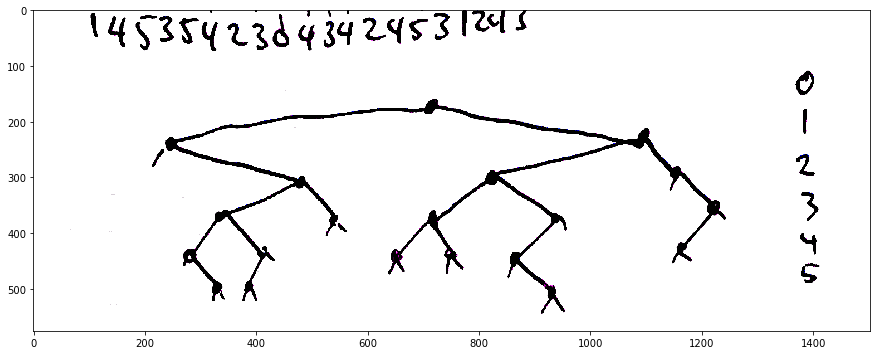

In [1056]:
plt.figure(figsize=(15,15))

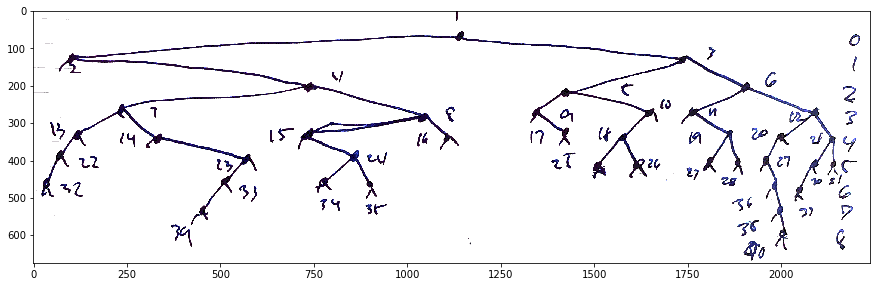

In [1058]:
plt.figure(figsize=(15,15))
plt.imshow(np.array(Image.open('40-node.png')))

Note now this allows a randomized algorithm for computing the full binary tree polynomial expression: for each level, do $10000$ or more trials, and collect the resulting statistics into a dictionary whose keys are the descriptors in question. The descriptors are in 1-1 correspondence with a variable term in the sum. The multiple trials are only needed to ensure that all cases of trees occur. It turns out that this algorithm is much faster than the crude "rewriting" algorithm we used. (For future reference, make sure to re-run the `FreeAlgebra` function above to re-establish the symbolic variables $x$ and $z$ that we were using)

In [1087]:
def tree_poly(n, num_trials=10000):
    result = x[0]*z + 1
    for degree in range(2, n+1):
        descriptor_dict = tree_stats(degree, num_trials=num_trials)
        for index_list in descriptor_dict:
            if ',' in index_list:
                index_list = [int(c) for c in index_list.split(',')]
            else:
                index_list = [int (c) for c in index_list]
            term = 1
            for ind in index_list:
                term *= x[ind]
            term *= z**degree
            result += term
    return result

In [1088]:
x[0], z

(x0, z)

In [1090]:
pretty_print(tree_poly(3))

1 + x0*z + x0*x1*z^2 + x1*x0*z^2 + x0*x1*x2*z^3 + x0*x2*x1*z^3 + x1*x0*x1*z^3 + x1*x2*x0*z^3 + x2*x1*x0*z^3

In [1092]:
tp6 = tree_poly(6)

In [1093]:
pretty_print(tp6)

1 + x0*z + x0*x1*z^2 + x1*x0*z^2 + x0*x1*x2*z^3 + x0*x2*x1*z^3 + x1*x0*x1*z^3 + x1*x2*x0*z^3 + x2*x1*x0*z^3 + x0*x1*x2*x3*z^4 + x0*x1*x3*x2*z^4 + x0*x2*x1*x2*z^4 + x0*x2*x3*x1*z^4 + x0*x3*x2*x1*z^4 + x1*x0*x1*x2*z^4 + x1*x0*x2*x1*z^4 + x1*x2*x0*x1*z^4 + x1*x2*x3*x0*z^4 + x1*x3*x2*x0*z^4 + x2*x1*x0*x1*z^4 + x2*x1*x2*x0*z^4 + x2*x3*x1*x0*z^4 + x3*x2*x1*x0*z^4 + x0*x1*x2*x3*x4*z^5 + x0*x1*x2*x4*x3*z^5 + x0*x1*x3*x2*x3*z^5 + x0*x1*x3*x4*x2*z^5 + x0*x1*x4*x3*x2*z^5 + x0*x2*x1*x2*x3*z^5 + x0*x2*x1*x3*x2*z^5 + x0*x2*x3*x1*x2*z^5 + x0*x2*x3*x4*x1*z^5 + x0*x2*x4*x3*x1*z^5 + x0*x3*x2*x1*x2*z^5 + x0*x3*x2*x3*x1*z^5 + x0*x3*x4*x2*x1*z^5 + x0*x4*x3*x2*x1*z^5 + x1*x0*x1*x2*x3*z^5 + x1*x0*x1*x3*x2*z^5 + x1*x0*x2*x1*x2*z^5 + x1*x0*x2*x3*x1*z^5 + x1*x0*x3*x2*x1*z^5 + x1*x2*x0*x1*x2*z^5 + x1*x2*x0*x2*x1*z^5 + x1*x2*x3*x0*x1*z^5 + x1*x2*x3*x4*x0*z^5 + x1*x2*x4*x3*x0*z^5 + x1*x3*x2*x0*x1*z^5 + x1*x3*x2*x3*x0*z^5 + x1*x3*x4*x2*x0*z^5 + x1*x4*x3*x2*x0*z^5 + x2*x1*x0*x1*x2*z^5 + x2*x1*x0*x2*x1*z^5 + x2*x1*x2*x0*x1*z^5 + x2*x1*x2*x3*x0*z^5 + x2*x1*x3*x2*x0*z^5 + x2*x3*x1*x0*x1*z^5 + x2*x3*x1*x2*x0*z^5 + x2*x3*x4*x1*x0*z^5 + x2*x4*x3*x1*x0*z^5 + x3*x2*x1*x0*x1*z^5 + x3*x2*x1*x2*x0*z^5 + x3*x2*x3*x1*x0*z^5 + x3*x4*x2*x1*x0*z^5 + x4*x3*x2*x1*x0*z^5 + x0*x1*x2*x3*x4*x5*z^6 + x0*x1*x2*x3*x5*x4*z^6 + x0*x1*x2*x4*x3*x4*z^6 + x0*x1*x2*x4*x5*x3*z^6 + x0*x1*x2*x5*x4*x3*z^6 + x0*x1*x3*x2*x3*x4*z^6 + x0*x1*x3*x2*x4*x3*z^6 + x0*x1*x3*x4*x2*x3*z^6 + x0*x1*x3*x4*x5*x2*z^6 + x0*x1*x3*x5*x4*x2*z^6 + x0*x1*x4*x3*x2*x3*z^6 + x0*x1*x4*x3*x4*x2*z^6 + x0*x1*x4*x5*x3*x2*z^6 + x0*x1*x5*x4*x3*x2*z^6 + x0*x2*x1*x2*x3*x4*z^6 + x0*x2*x1*x2*x4*x3*z^6 + x0*x2*x1*x3*x2*x3*z^6 + x0*x2*x1*x3*x4*x2*z^6 + x0*x2*x1*x4*x3*x2*z^6 + x0*x2*x3*x1*x2*x3*z^6 + x0*x2*x3*x1*x3*x2*z^6 + x0*x2*x3*x4*x1*x2*z^6 + x0*x2*x3*x4*x5*x1*z^6 + x0*x2*x3*x5*x4*x1*z^6 + x0*x2*x4*x3*x1*x2*z^6 + x0*x2*x4*x3*x4*x1*z^6 + x0*x2*x4*x5*x3*x1*z^6 + x0*x2*x5*x4*x3*x1*z^6 + x0*x3*x2*x1*x2*x3*z^6 + x0*x3*x2*x1*x3*x2*z^6 + x0*x3*x2*x3*x1*x2*z^6 + x0*x3*x2*x3*x4*x1*z^6 + x0*x3*x2*x4*x3*x1*z^6 + x0*x3*x4*x2*x1*x2*z^6 + x0*x3*x4*x2*x3*x1*z^6 + x0*x3*x4*x5*x2*x1*z^6 + x0*x3*x5*x4*x2*x1*z^6 + x0*x4*x3*x2*x1*x2*z^6 + x0*x4*x3*x2*x3*x1*z^6 + x0*x4*x3*x4*x2*x1*z^6 + x0*x4*x5*x3*x2*x1*z^6 + x0*x5*x4*x3*x2*x1*z^6 + x1*x0*x1*x2*x3*x4*z^6 + x1*x0*x1*x2*x4*x3*z^6 + x1*x0*x1*x3*x2*x3*z^6 + x1*x0*x1*x3*x4*x2*z^6 + x1*x0*x1*x4*x3*x2*z^6 + x1*x0*x2*x1*x2*x3*z^6 + x1*x0*x2*x1*x3*x2*z^6 + x1*x0*x2*x3*x1*x2*z^6 + x1*x0*x2*x3*x4*x1*z^6 + x1*x0*x2*x4*x3*x1*z^6 + x1*x0*x3*x2*x1*x2*z^6 + x1*x0*x3*x2*x3*x1*z^6 + x1*x0*x3*x4*x2*x1*z^6 + x1*x0*x4*x3*x2*x1*z^6 + x1*x2*x0*x1*x2*x3*z^6 + x1*x2*x0*x1*x3*x2*z^6 + x1*x2*x0*x2*x1*x2*z^6 + x1*x2*x0*x2*x3*x1*z^6 + x1*x2*x0*x3*x2*x1*z^6 + x1*x2*x3*x0*x1*x2*z^6 + x1*x2*x3*x0*x2*x1*z^6 + x1*x2*x3*x4*x0*x1*z^6 + x1*x2*x3*x4*x5*x0*z^6 + x1*x2*x3*x5*x4*x0*z^6 + x1*x2*x4*x3*x0*x1*z^6 + x1*x2*x4*x3*x4*x0*z^6 + x1*x2*x4*x5*x3*x0*z^6 + x1*x2*x5*x4*x3*x0*z^6 + x1*x3*x2*x0*x1*x2*z^6 + x1*x3*x2*x0*x2*x1*z^6 + x1*x3*x2*x3*x0*x1*z^6 + x1*x3*x2*x3*x4*x0*z^6 + x1*x3*x2*x4*x3*x0*z^6 + x1*x3*x4*x2*x0*x1*z^6 + x1*x3*x4*x2*x3*x0*z^6 + x1*x3*x4*x5*x2*x0*z^6 + x1*x3*x5*x4*x2*x0*z^6 + x1*x4*x3*x2*x0*x1*z^6 + x1*x4*x3*x2*x3*x0*z^6 + x1*x4*x3*x4*x2*x0*z^6 + x1*x4*x5*x3*x2*x0*z^6 + x1*x5*x4*x3*x2*x0*z^6 + x2*x1*x0*x1*x2*x3*z^6 + x2*x1*x0*x1*x3*x2*z^6 + x2*x1*x0*x2*x1*x2*z^6 + x2*x1*x0*x2*x3*x1*z^6 + x2*x1*x0*x3*x2*x1*z^6 + x2*x1*x2*x0*x1*x2*z^6 + x2*x1*x2*x0*x2*x1*z^6 + x2*x1*x2*x3*x0*x1*z^6 + x2*x1*x2*x3*x4*x0*z^6 + x2*x1*x2*x4*x3*x0*z^6 + x2*x1*x3*x2*x0*x1*z^6 + x2*x1*x3*x2*x3*x0*z^6 + x2*x1*x3*x4*x2*x0*z^6 + x2*x1*x4*x3*x2*x0*z^6 + x2*x3*x1*x0*x1*x2*z^6 + x2*x3*x1*x0*x2*x1*z^6 + x2*x3*x1*x2*x0*x1*z^6 + x2*x3*x1*x2*x3*x0*z^6 + x2*x3*x1*x3*x2*x0*z^6 + x2*x3*x4*x1*x0*x1*z^6 + x2*x3*x4*x1*x2*x0*z^6 + x2*x3*x4*x5*x1*x0*z^6 + x2*x3*x5*x4*x1*x0*z^6 + x2*x4*x3*x1*x0*x1*z^6 + x2*x4*x3*x1*x2*x0*z^6 + x2*x4*x3*x4*x1*x0*z^6 + x2*x4*x5*x3*x1*x0*z^6 + x2*x5*x4*x3*x1*x0*z^6 + x3*x2*x1*x0*x1*x2*z^6 + x3*x2*x1*x0*x2*x1*z^6 + x3*x2*x1*x2*x0*x1*z^

That took only 5 seconds, rather than the other that took more than 60. I verified all $132$ degree-$6$ terms were there (because the terms are rendered in this notebook in an $8\times 16$ grid, and the remaining $4$ are easily spotted. But let's not leave it to sharp eyes:

In [1094]:
pretty_print(tp6.subs({x[d]: 1 for d in range(10)}))

1 + z + 2*z^2 + 5*z^3 + 14*z^4 + 42*z^5 + 132*z^6

Yup, $132$ as promised. Anyway we should note the reason for the interesting statistics. As noted, there are many more permutations than tree shapes with that same number of nodes. We can examine some small cases to see why. For example, the permutations $2,1,3$ and $2,3,1$ both lead to the balanced (`101`) tree. The rest of the permutations of $(1,2,3)$ correspond uniquely to the remaining trees. So when averaging the number of leaves over all tree shapes, we get the expected number of leaves is $\frac{1}{5}$ times $2$ (for the two leaves of the balanced tree), plus $\frac{4}{5}$ times $1$ (all the remaining trees have only one leaf), for a total of $\frac{6}{5} = 1.2$ leaves for a $3$ element tree. But when considering permutations, two permutations hit the balanced tree with $2$ leaves, and the remaining permutations get tres with only $1$ leaf. So the expected number of leaves, _relative to permutations_, is $2 \cdot \frac{1}{3} + 1 \cdot \frac{2}{3} = \frac{4}{3}$ leaves, rather than $\frac{6}{5}$ leaves.

The result given in the Analytic Combinatorics course is that given a particular tree, we can count how many permutations will achieve that tree. The way to do this first to determine the sizes of the left and right subtrees; this fixes what the root must be. Say $T$ is $T_L \times r \times T_R$. Then if we assume that the integers $0$ through $N-1$ are in the tree, the root must contain the key $|T_L|$, and $T_R$ consists of nodes entirely of the nodes $ > |T_L|$. Now, if some particular permutation of $0$ through $|T_L|-1$ fills out the left subtree, and permutations of $|T_L|+1$ through $N$ fill out the right subtree, these two may be _shuffled_ within each other. Namely, the insertion order corresponds to $|T_L|$ first (to get the root), then the nodes $0$ through $|T_L|-1$ can alternate in any pattern with the nodes $|T_L|+1$ through $N$, but indices from the same set must maintain their relative ordering. Well, not _must_, really, rather we use recursion: we look inductively at the count of permutations that will fill out $T_L$ and the count of permutations that will fill out $T_R$. The reason why we can alternate between the two left and right trees in any fashion we want is that each insertion that goes into the right subtree completely ignores the left subtree, and vice versa, so that so long as we preserve the ordering of insertions into the left tree amongst nodes that actually belong in it, the shape of the tree formed should also be the same. So if $P_{T}$ denotes the number of permutations of $N$ nodes that will fill out this tree $T$, the result is the number of shufflings times $P_{T_L} P_{T_R}$. What is the number of shufflings of $[0, |T_L|)$ and $[|T_L|+1, N)$? It is simply removing $|T_L|$ from consideration (since that we know must come first, as it is what occupies the root), and letting one of the permutations fill $|T_L|$ out of the remaining $N-1$ available slots. So the total is

$$
P_T = {N - 1 \choose |T_L|} P_{T_L} P_{T_R} \qquad (|T|=N)
$$

For example, the balanced $3$-node tree splits into root and single node in $L$ and $R$. The single node has a unique representations ($P_{T_L} = 1 = P_{T_R}$), and $|T_L|=1$. Finally, $|T|-1 = 2$, so the total number of permutations achieving $T$ is ${2 \choose 1} \cdot 1 \cdot 1 = 2$.


Similarly let's count how often the `120212` $6$-element tree above is achieved. This is just the fully balanced $7$-element tree except with the lower left node missing. So therefore the right subtree is the $3$-element balanced tree that we just calculated ($P_{T_R} = 2$), and the left subtree is a $2$-element tree. This makes $P_{T_L} = 1$ and $|T_L| = 2$. Therefore the total number of trees is ${ 6 - 1 \choose 2 } \cdot 1 \cdot 2 = 20$. Thus in a trial of $10000$, somewhere around $10000 \cdot (20/720) = 277.78$ trees should be found.

In [1060]:
10000*(20/720.0)

277.777777777778

This is in excellent agreement with what we actually simulated, 280. Finally let's see how often we can expect `2120212`, the perfectly balanced binary tree of $7$ nodes. This is ${7-1 \choose 3}\cdot 2 \cdot 2 = 80$. Then $80/7! \cdot 50000 = 793.65$ permutations should hit this, in a trial of $50000$. Similarly, the next smaller, `3231201` consists of, surprisingly, $T_L$ a tree of $5$ elements but a $T_R$ a tree of only one element. ${6\choose 5} = 6$. Now this left $5$ element subtree consists of a root, $3$-element subtree, and a $1$-element subtree to the right. Thus it contributes ${ 4 \choose 3} = 4$. A final factor of $2$ is the number of balanced $3$ element trees achieved by permutations, namely what we calculated above. For a total of $6 \cdot 4 \cdot 2 = 48$. Then $48/7! \cdot 50000 = 476.19$ trees, also in agreement with the simulation. It is surprising, though, that this is the second most common arrangement. Quite the drop-off.

In [1062]:
80/5040.0 * 50000

793.650793650794

In [1064]:
48/5040.0 * 50000

476.190476190476

This is the interesting Catalan distribution.

In [1065]:
45/5040.0 * 50000

446.428571428571

## Counting Leaves, Continued

Ok. As practice, let's derive the average height of a tree based on a uniform distribution of tree shapes. Finally, we'll derive statistics for both height and number of leaves based on permutations rather than tree shapes.

We use the same technique for counting trees and leaves: we define the cumulated heights for every tree at level $N$ as

$$
H(z) = \sum_{t \in T} H_t z^{|t|}.
$$

Now given a tree, the height is $1$ plus the maximum of the height of its left subtree and its right subtree (we implemented this in the above quite trivially). This means

$$
H(z) = \sum_{t_L, t_R \in T} \left(1+\max(H_{t_R}, H_{t_L})\right) z^{|t_R| + |t_L| + 1}.
$$

This is a bit more complicated than before, because maximum doesn't behave as well with respect to addition. Let's see where the trouble occurs and postpone the development:

$$
H(z) = T(z) + \sum_{t_L \in T} \left(\sum_{t_R \in T} \max(H_{t_R}, H_{t_L}) z^{|t_R|}\right) z^{|t_L|+1}  = T(z) + \sum_{t_L \in T} \left(\sum_{\substack{t_R \in T \\ H_{t_R} > H_{t_L}}} H_{t_R} z^{|t_R|}\right) z^{|t_L|+1}
$$

It is not clear how to sum over the smaller set, since the break into situations where the right subtree is taller than the left doesn't have a clean recursive description.

Anyway, let's proceed with the analysis with respect to permutations. For the number of leaves, we sum the cumulated sum using EGFs:

$$
G(z) = \sum_{p \in P} \ell(p) \frac{z^{|p|}}{|p|!} = \sum_{n=0}^\infty \sum_{p \in S_n} \frac{\ell(p)}{n!} z^n.
$$

To decompose this sum, we split into permutations for a left subtree and permutations for a right subtree, and finally a root, just as before, but only when $n \geq 2$, since the leaf function at the root is $1$, and not the sum of the leaves of the two subtrees, which would be zero. We could also encode it using Iverson brackets, but separating the exceptional terms will be easier in this case:

$$
G(z) = \sum_{p \in P} \ell(p) \frac{z^{|p|}}{|p|!} = z + \sum_{p_L \in P} \sum_{p_R \in P} {|p_L| + |p_R| \choose |p_L|}\left(\ell(p_L) + \ell(p_R) \right) \frac{z^{|p_L| + |p_R| + 1}}{(|p_L| + |p_R| + 1)!}
$$

Here we used the binomial coefficient for the shufflings, as in our previous calculations. To recast it into terms that are a little more familiar, collect terms on the basis of degrees as we usually do, for all occurrences of $p_L$ and $p_R$:

$$
G(z) = z + \sum_{n\geq 2} \left(\sum_{k=0}^{n-1} {n-1 \choose k} \sum_{p_L \in S_k} \sum_{p_R \in S_{n-1-k}} (\ell(p_L) + \ell(p_R)) \right)\frac{z^n}{n!}
$$

Basically, we've summed over the size of $p_L$, and the size of the whole tree, so that constrains $p_R$ to be of size $n-1-k$, the $-1$ coming from counting the root separately. The binomial coefficient is similarly choosing out of $n-1$, since the root is fixed (to always be the first insert), so that the remaining permutations can only be shuffled among $n-1$ slots. The mismatch of $n$ in $z^n/n!$ and the $n-1$ in the binomial coefficient (as well as the specific summation indices) is one that frequently occurs when dealing with EGFs and permutations; the way to fix it is via differentiation. First, let's make the summation indices not involve $-1$'s, and put the extra power on the $z$, since that's what we're differentiating (the goal in mind is to get this to look like a convolution of EGFs, so that the functional relation is simply expressible as a product of EGFs):

$$
G(z) = z +\sum_{n\geq 1} \left(\sum_{k=0}^{n} {n \choose k} \sum_{p_L \in S_k} \sum_{p_R \in S_{n-k}} (\ell(p_L) + \ell(p_R)) \right)\frac{z^{n+1}}{(n+1)!}
$$

which then leads, after differentiation, to

$$
G'(z) = 1 +\sum_{n\geq 1} \left(\sum_{k=0}^{n} {n \choose k} \sum_{p_L \in S_k} \sum_{p_R \in S_{n-k}} (\ell(p_L) + \ell(p_R)) \right)\frac{z^{n}}{n!}.
$$

Finally, we can separate the sums over $p_L$ and $p_R$. By the symmetry of the binomial coefficients, we can see this is the same as simply twice the sum over the left leaves only:

$$
G'(z) = 1 +\sum_{n\geq 1} \left(\sum_{k=0}^{n} {n \choose k} \sum_{p_L \in S_k} \sum_{p_R \in S_{n-k}} 2\ell(p_L)  \right)\frac{z^{n}}{n!} = 1 +\sum_{n\geq 1} \left(\sum_{k=0}^{n} {n \choose k} \left(\sum_{p_L \in S_k} \ell(p_L)\right)\left( \sum_{p_R \in S_{n-k}} 2\right)  \right)\frac{z^{n}}{n!} 
$$


Now the two parenthesized sums multiplying one another, together with the binomial coefficient, is the coefficient corresponding to the Cauchy product of EGFs. Namely, if we take $g_n = \sum_{p \in S_n} \ell(p)$ and $p_n = \sum_{p \in S_n} 2 = 2n!$, then the coefficient is $\sum_{k=0}^n {n \choose k} a_k g_{n-k}$, and with $P(z) = \sum_n \frac{p_n}{n!} z^n = \frac{2}{1-z}$ and $G(z) = \sum_n \frac{g_n}{n!} z^n$, that big summation is just $P(z) G(z)$. All in all, we have

$$
G'(z) = 1 + G(z)P(z) = 1+ \frac{2}{1-z} G(z).
$$

Using the method of integrating factors for first order linear ODEs, if we take the integrating factor $\exp\left(\int -\frac{2}{1-z} dz\right) = \exp\left( -2 \ln\frac{1}{1-z}\right) = (1-z)^2$, we can solve the ODE:

$$
((1-z)^2 G)'(z) = 1 \cdot (1-z)^2,
$$
$$
(1-z)^2 G(z) = -\frac{(1-z)^3}{3} + D,
$$
for some constant $D$, and finally
$$
G(z) = -\frac{1-z}{3} + \frac{D}{(1-z)^2}.
$$

We can determine the $D$ by looking at the first few coefficients. First,

$$
G(z) = -\frac{1-z}{3} + D + 2Dz + 3Dz^2 + 4Dz^3 + \cdots
$$

as $\frac{1}{(1-z)^2}$ is the derivative of the geometric series. This immediately pinpoints $D = \frac{1}{3}$ as that is needed to cancel out the $-\frac{1}{3}$. So therefore

$$
G(z) = \left(\frac{1}{3} + \frac{2}{3}\right)z + \sum_{n\geq 2} \frac{n+1}{3} z^n = z + \sum_{n\geq 2} \frac{n+1}{3} z^n.
$$

To find the average number of leaves per length-$N$ permutation, we take $N! [z^{N}] G(z)/N!$ (the first $N!$ coming from the usual way of dealing with coefficients of EGFs, and the second coming from counting permutations), and so the result is $\frac{N+1}{3}$. This is in excellent agreement with what we actually found, both from simulation and counting manually which $3$-element trees are achieved by which permutations. Note also that this expected value is exact, not (just) asymptotic, unlike the case for Catalan trees, in which the expectation is asymptotic to $\frac{N}{4}$.

## Internal Path Length

Another interesting quantity corresponding to trees is internal path length. This is the sum of the total path lengths for every node in the tree: every node has a unique path from the root, and that path has a length. It's probably easiest to describe recursively (Sedgewick does mention a level-by-level computation in his lecture on the subject, so look at that).

# And Finally, a Visualizer

This does an inorder traversal of the tree and writes all the keys out. They should always occur in sorted order.

In [1383]:
def inorder_viz_points(tree):
    inorder_list = []
    def inorder(tree_node, previous, level):
        if tree_node is None:
            return 
        left_null = inorder(tree_node.left, (tree_node.value, level), level+1)
        inorder_list.append((previous, (tree_node.value, level)))
        right_null = inorder(tree_node.right, (tree_node.value, level), level+1)
    inorder(tree.root, None, 0)
    return inorder_list
    

Random permutation of 400 nodes.

In [1395]:
randperm = np.random.permutation(range(400))
rtree = Tree()
rtree.mass_insert(*randperm)

In [1396]:
torder = inorder_viz_points(rtree)

In [1397]:
torder

[((1, 2), (0, 3)),
 ((11, 1), (1, 2)),
 ((3, 4), (2, 5)),
 ((6, 3), (3, 4)),
 ((3, 4), (4, 5)),
 ((4, 5), (5, 6)),
 ((1, 2), (6, 3)),
 ((6, 3), (7, 4)),
 ((7, 4), (8, 5)),
 ((10, 6), (9, 7)),
 ((8, 5), (10, 6)),
 ((214, 0), (11, 1)),
 ((13, 7), (12, 8)),
 ((14, 6), (13, 7)),
 ((18, 5), (14, 6)),
 ((14, 6), (15, 7)),
 ((17, 8), (16, 9)),
 ((15, 7), (17, 8)),
 ((94, 4), (18, 5)),
 ((20, 10), (19, 11)),
 ((24, 9), (20, 10)),
 ((20, 10), (21, 11)),
 ((23, 12), (22, 13)),
 ((21, 11), (23, 12)),
 ((32, 8), (24, 9)),
 ((26, 11), (25, 12)),
 ((27, 10), (26, 11)),
 ((24, 9), (27, 10)),
 ((29, 11), (28, 12)),
 ((27, 10), (29, 11)),
 ((31, 12), (30, 13)),
 ((29, 11), (31, 12)),
 ((44, 7), (32, 8)),
 ((39, 10), (33, 11)),
 ((33, 11), (34, 12)),
 ((38, 13), (35, 14)),
 ((35, 14), (36, 15)),
 ((36, 15), (37, 16)),
 ((34, 12), (38, 13)),
 ((40, 9), (39, 10)),
 ((32, 8), (40, 9)),
 ((42, 11), (41, 12)),
 ((43, 10), (42, 11)),
 ((40, 9), (43, 10)),
 ((76, 6), (44, 7)),
 ((46, 8), (45, 9)),
 ((44, 7), (

In [1398]:
def unzip(lis):
    return [t[0] for t in lis], [t[1] for t in lis]
def reflect(y):
    return -np.array(y)

First visualization: inorder traversal is the $x$-coordinate, (minus) the level is the $y$-coordinate.

In [1420]:
def viz_tree(inorder_list):
    _, nodes = unzip(inorder_list)
    non_nones = [t for t in inorder_list if t[0] is not None]
    parents, non_roots = unzip(non_nones)
    x, y = unzip(nodes)
    y = -np.array(y)
    ax = plt.axes()
    ax.scatter(np.arange(len(y)), y)
    x, y = unzip(non_roots)
    y = -np.array(y)
    non_roots = np.stack([x, y], axis=-1)
    x, y = unzip(parents)
    y = -np.array(y)
    parents = np.stack([x, y], axis=-1)
    lc = mc.LineCollection(np.stack([parents, non_roots], axis=1))
    ax.add_collection(lc)

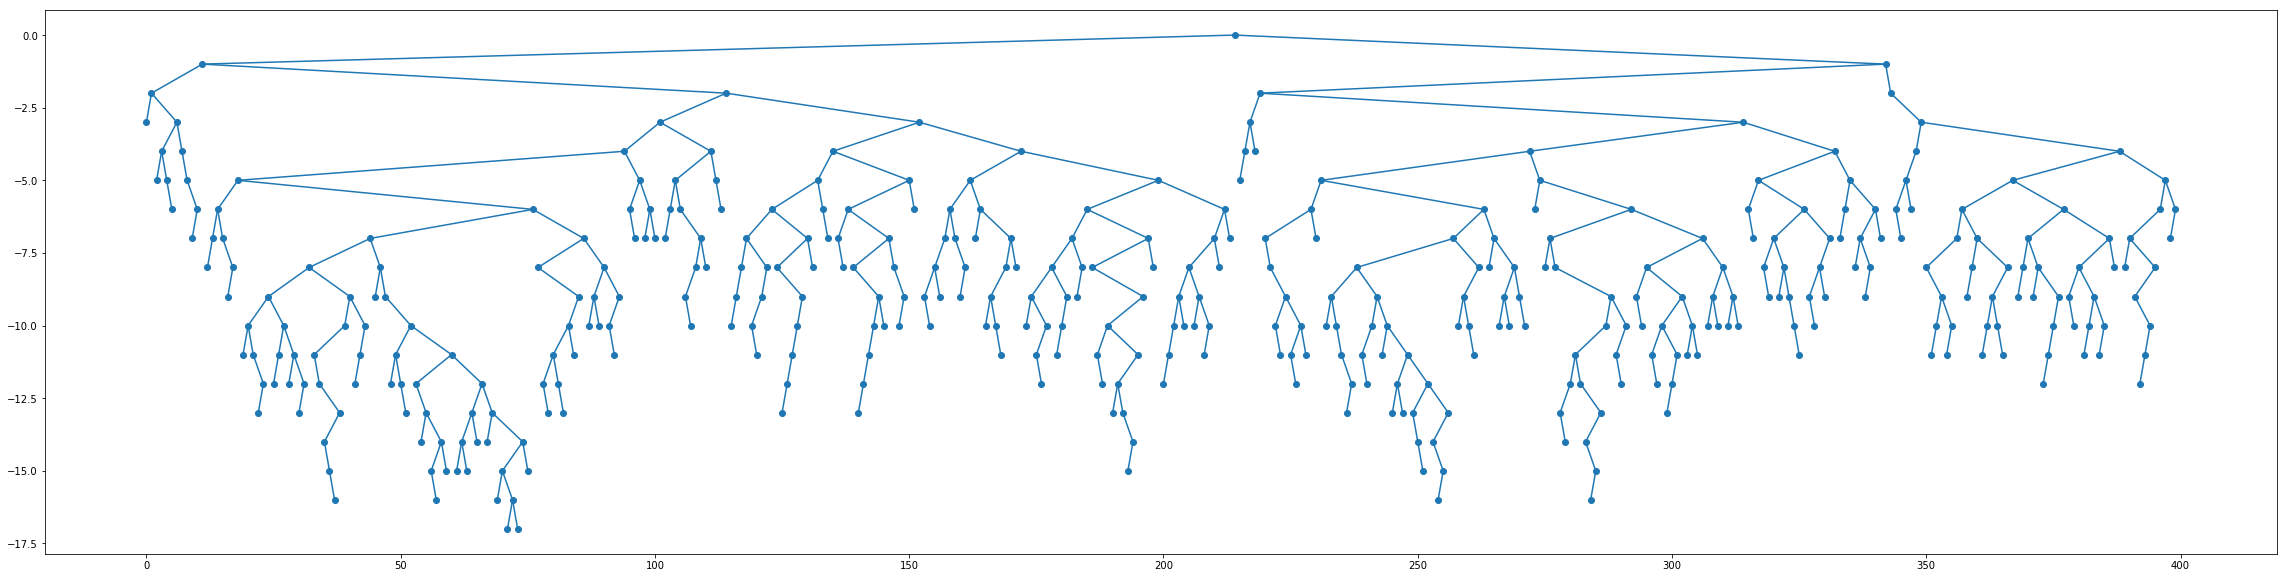

In [1435]:
plt.figure(figsize=(40,10))
internals = viz_tree(torder)

In [1215]:
from matplotlib import collections as mc

lc = mc.LineCollection([list(l) for l in non_nones])

In [1192]:
_, starts = unzip(torder)
torder_x, torder_y = unzip(starts)

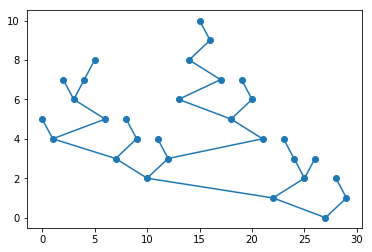

In [1193]:
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.scatter(torder_x, torder_y)

More sophisticated version that centers the number of nodes on each level. This leads to a useful tree profile.

In [1421]:
def viz_centered(inorder_list):
    level_dict = collections.defaultdict(list)
    pdict = {}
    coord_dict = {}
    for parent, node in inorder_list:
        key, level = node
        pkey, _ = parent if parent is not None else (None, None)
        pdict[key] = pkey 
        level_dict[level].append(key)
    
    for level, keys in level_dict.items():
        N = len(keys)
        mag = (N-1)/2
       
        j = -mag
        for k in keys:
            coord_dict[k] = (j, level)
            j += 1
    
    line_collection = []
    scatter_x, scatter_y = [], []
    for level, keys in level_dict.items():
        for k in keys:
            x, y = coord_dict[k]
            scatter_x.append(x)
            scatter_y.append(-y)
            pk = pdict[k]
            if pk is None: continue
            z, w = coord_dict[pk]
            line_collection.append([[x, -y], [z, -w]])
    
    ax = plt.axes()
    ax.scatter(scatter_x, scatter_y)
    ax.add_collection(mc.LineCollection(line_collection))

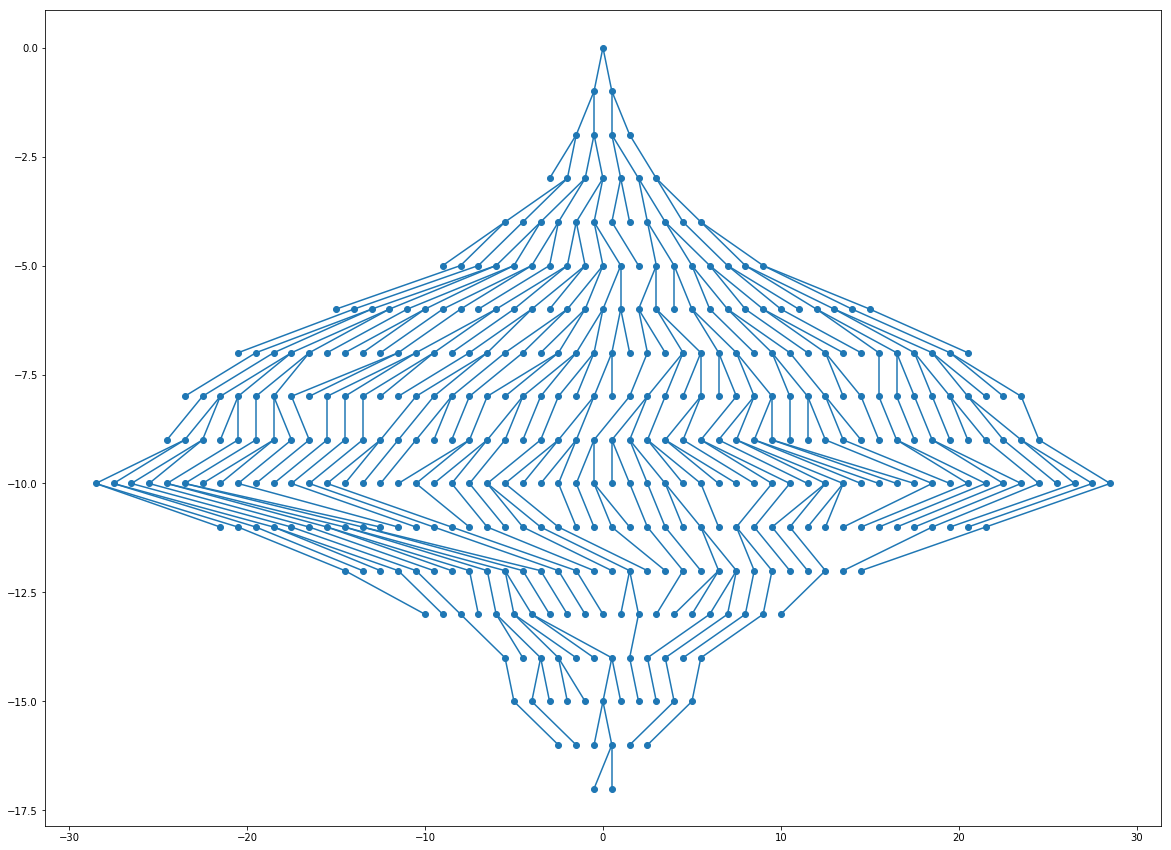

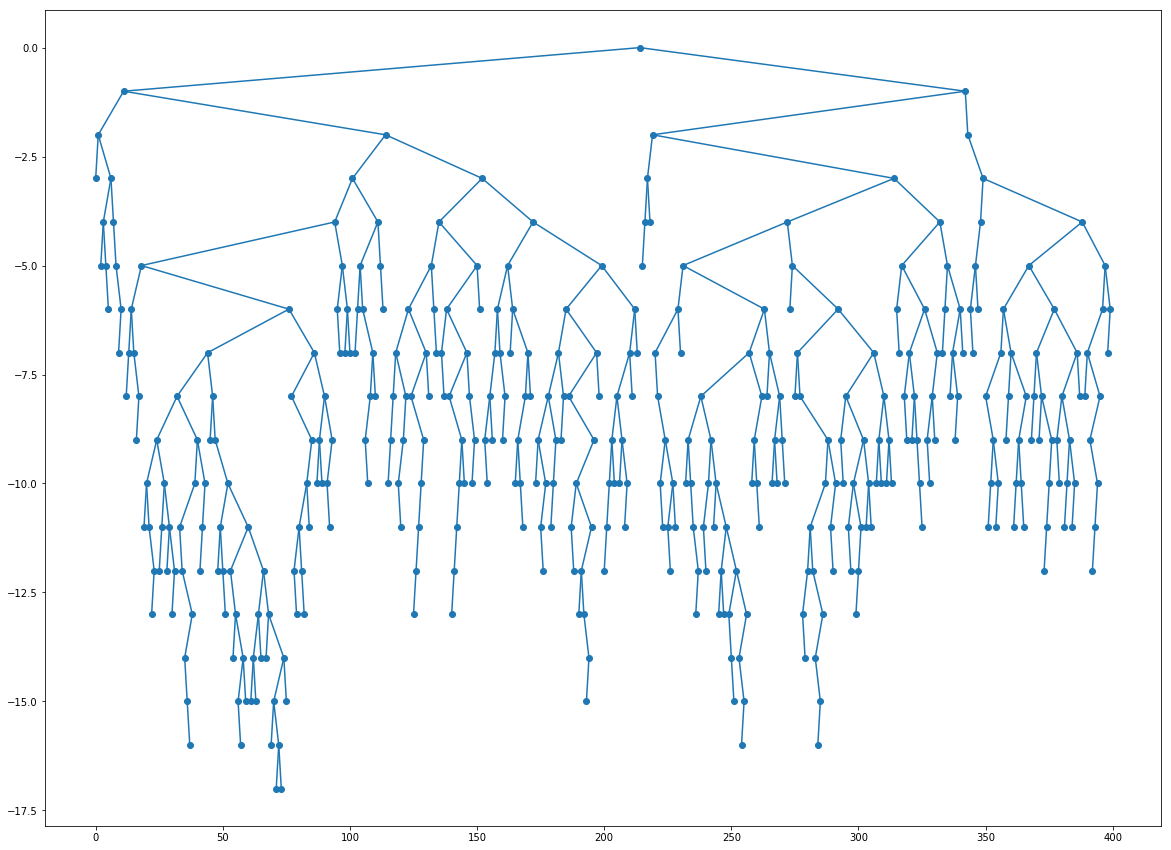

In [1429]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
viz_centered(torder)
plt.figure(figsize=(20,15))
plt.subplot(1,2,2)
viz_tree(torder)

# Visual Sample of Random Binary Search Trees

Now let us visualize some typical examples of random binary search trees, using the model of random permutations as before.

In [1424]:
def randtree(N):
    rtree = Tree()
    rtree.mass_insert(*np.random.permutation(range(N)))
    return rtree

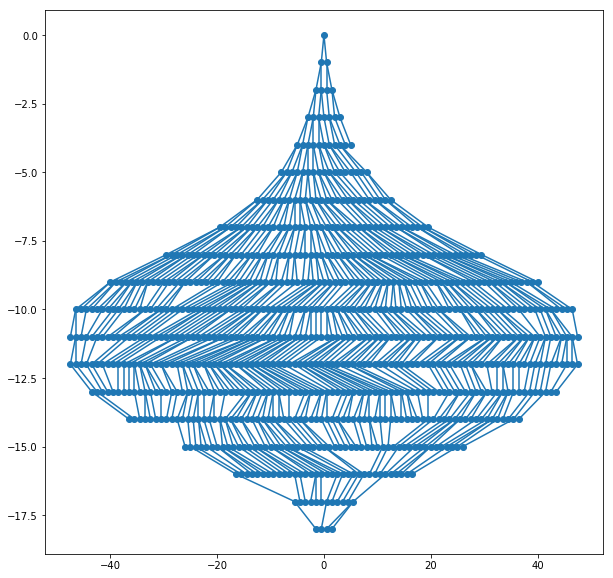

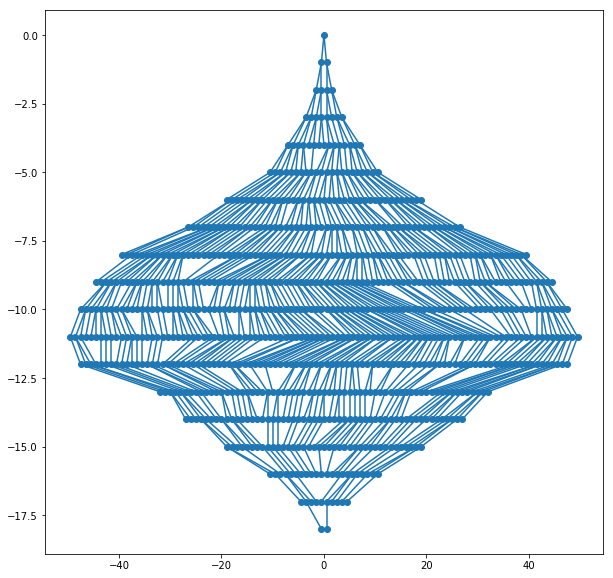

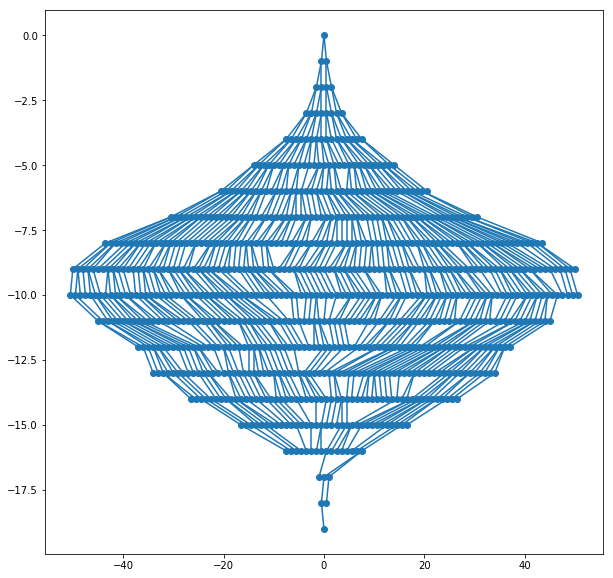

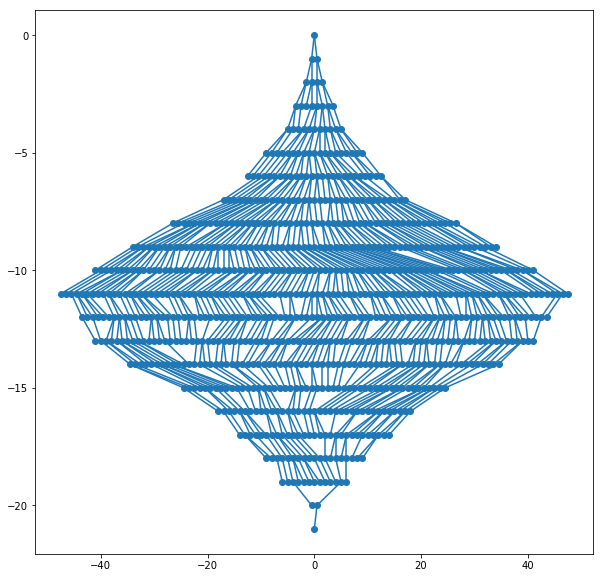

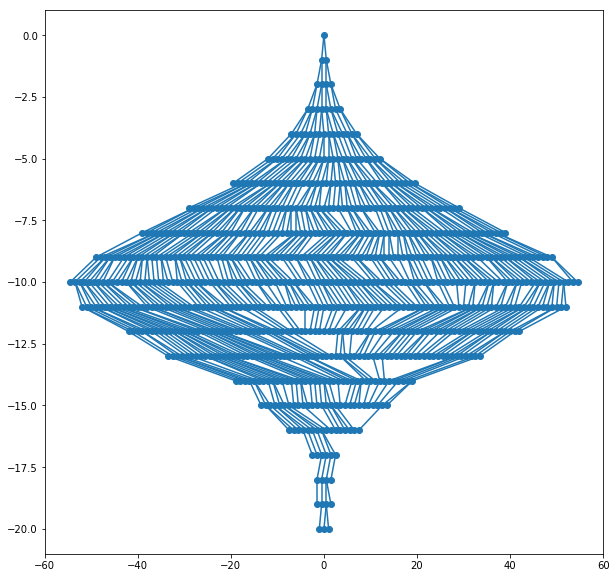

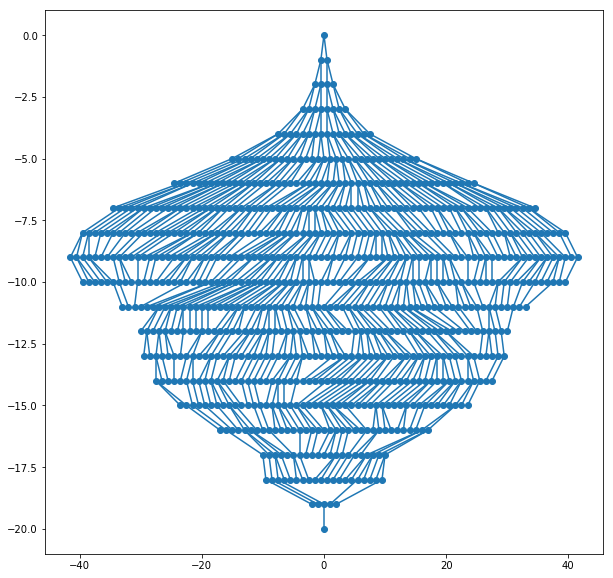

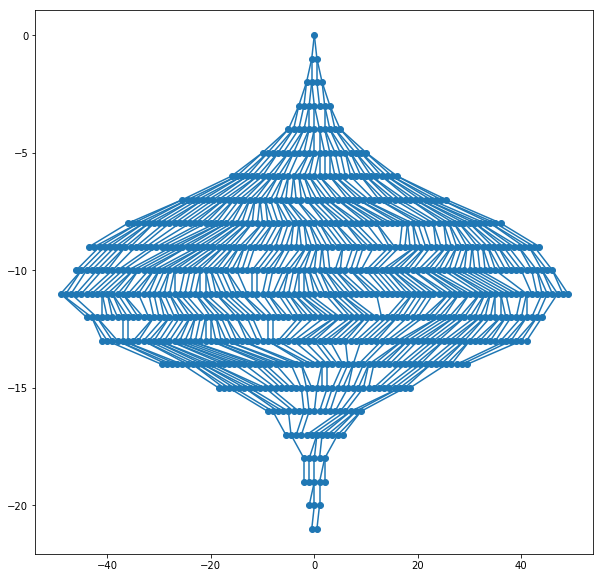

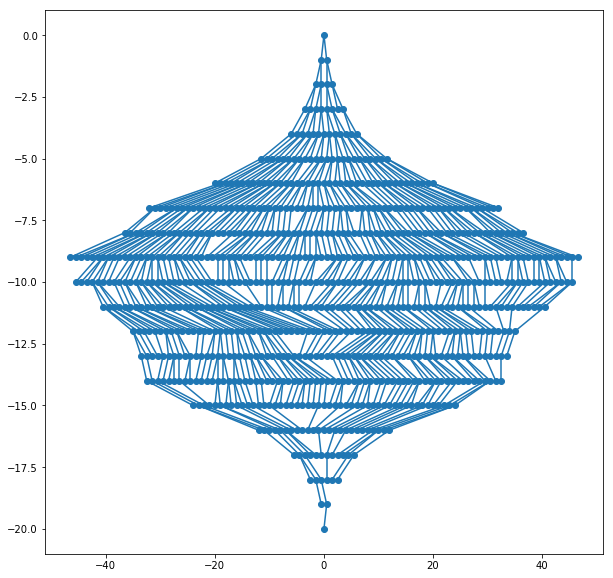

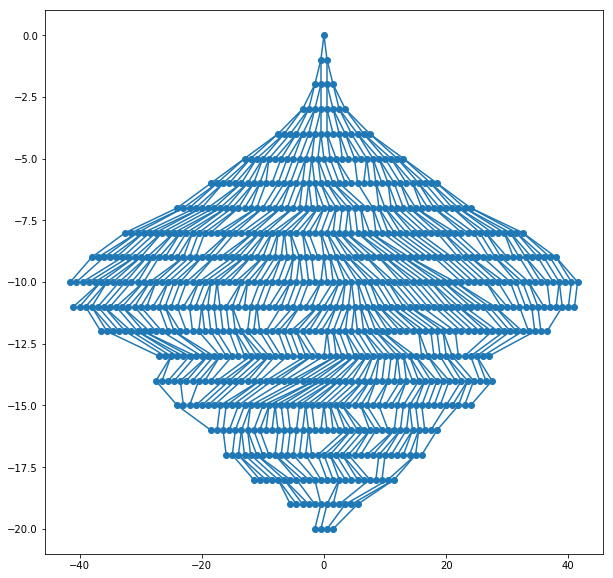

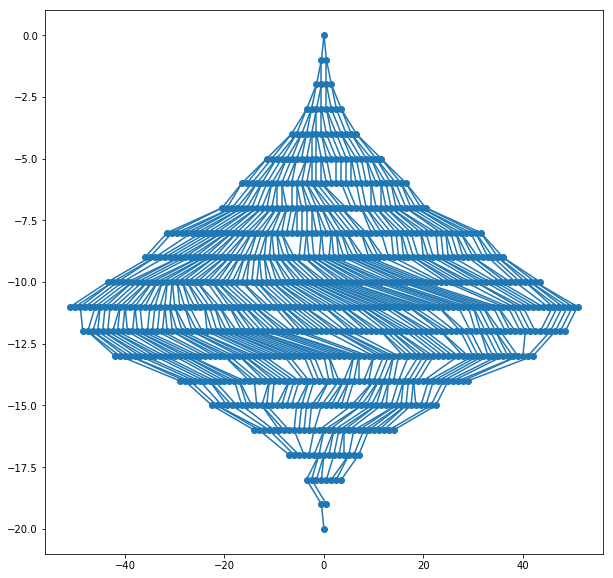

In [1434]:
for i in range(10):
    plt.figure(figsize=(10,10))
    viz_centered(inorder_viz_points(randtree(800)))

Some pretty cool-looking lanterns. Since typically there is a much higher probability that the trees are balanced, this gives a "wide middle". To get a uniform distribution using the Catalan distribution (namely, each tree of size $n$ is $1/c_n$) this is something different, which does not bias toward balanced trees. Currently we lack the sophistication to do that, though; we develop more of the theory below.

# More Refined Child Classification

Some sophisticated additional calculations. Let's compute the number of "internal internal" nodes, that is, nodes both of whose children are interior. I did the derivation on paper, and honestly am not feeling the asymptotic derivation. The result is 

$$
\frac{z(T(z) - 1)^2}{1-2zT(z)}
$$

the denominator is $1-2zT(z) = \sqrt{1-4z}$, just like for the description of the leaves $C(z)$ above. In fact, it's just $C(z)(T(z)-1)^2$.

For exactly child, the sum is a bit more complicated, because there's a very specific breakdown we must consider; it is most conveniently expressed using the Iverson bracket. The result is

$$
\frac{2z(T(z) - 1)}{1-2zT(z)}.
$$

The exponent of $2$ has been brought down to be a coefficient instead, so to speak (this is almost certainly just a coincidence).

In [1437]:
import sympy
w = sympy.symbols('w')

In [1439]:
TT = (1 - sympy.sqrt(1-4*w))/(2*w)

In [1441]:
pretty_print(TT)

-1/2*(sqrt(-4*w + 1) - 1)/w

In [1442]:
II = w*(TT-1)**2/(1-2*w*TT)

In [1443]:
II.series(n=13)

In [1466]:
EE = w*(TT-1)*2/(1-2*w*TT)
EE.series(n=13)

For completeness, let's get the series for leaves as well. Of course, it should just add up to the Catalan number  times the exponent (number of trees times number of nodes in the tree) when matched up with the corresponding coefficients for the above two, but what the heck.

In [1482]:
LL = w/(1-2*w*TT)
LL.series(n=13)

In [1444]:
def count_2(t):
    def count_2_helper(tree_node):
        if tree_node is None:
            return 0
        count = count_2_helper(tree_node.left) + count_2_helper(tree_node.right)
        if tree_node.left is not None and tree_node.right is not None:
            count += 1
        return count
    return count_2_helper(t.root)
        

In [1475]:
def count_1(t):
    def count_1_helper(tree_node):
        if tree_node is None:
            return 0
        count = count_1_helper(tree_node.left) + count_1_helper(tree_node.right)
        exactly_one = (int(tree_node.left is None) - int(tree_node.right is None))**2
        count += exactly_one 
        return count
    return count_1_helper(t.root)

In [1451]:
five_dict = collections.defaultdict(list)
for _ in range(1000):
    perm = np.random.permutation(range(5))
    t = Tree()
    t.mass_insert(*perm)
    five_dict[''.join([str(d) for d in t.shape_descriptor()])].append(t)
    

In [1452]:
len(five_dict)

In [1454]:
short_five_dict = {
    k: v[0]
    for k, v in five_dict.items()
}

In [1455]:
short_five_dict.keys()

dict_keys(['21021', '12301', '02132', '10212', '12021', '02312', '13230', '03212', '10123', '32120', '13420', '21012', '21230', '21201', '10231', '43210', '13201', '32101', '12012', '10321', '32310', '10132', '23101', '21320', '23120', '01323', '01243', '03231', '24310', '02431', '34210', '02123', '04321', '02341', '01234', '01432', '14320', '03421', '12340', '23410', '01342', '12430'])

In [1456]:
count_2(short_five_dict['21021'])

1

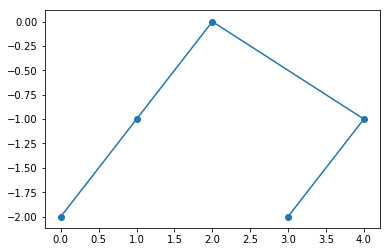

In [1457]:
viz_tree(inorder_viz_points(short_five_dict['21021']))

/Applications/SageMath-9.1.app/Contents/Resources/sage/local/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


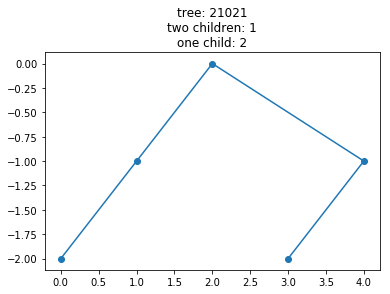

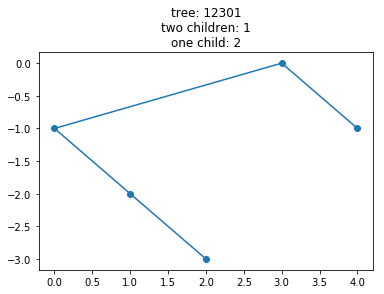

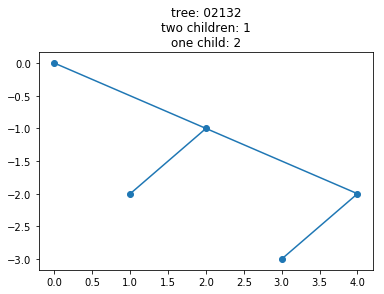

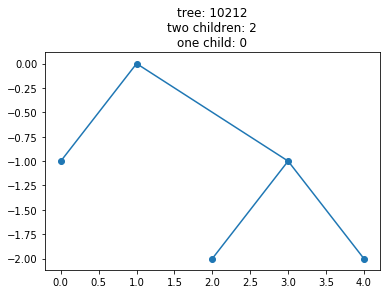

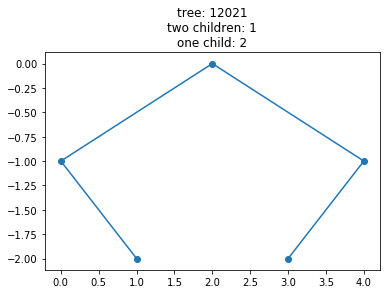

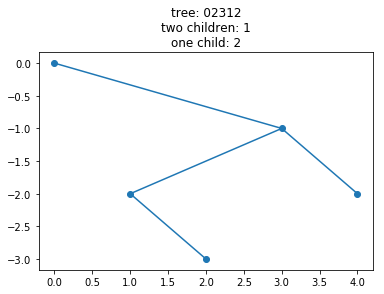

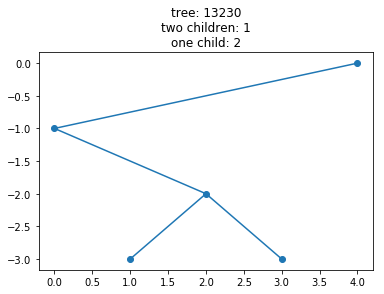

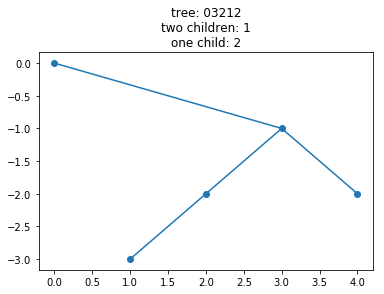

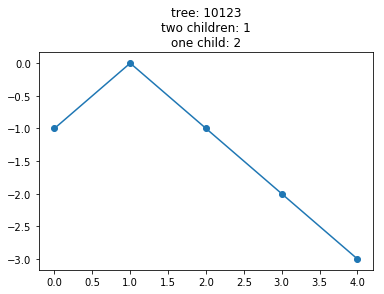

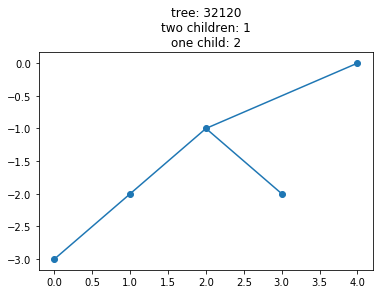

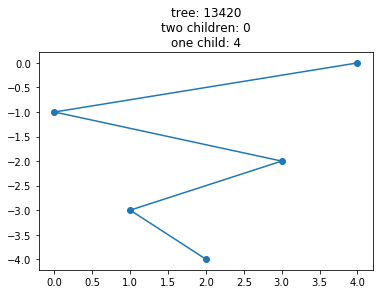

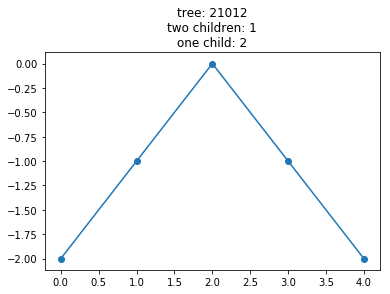

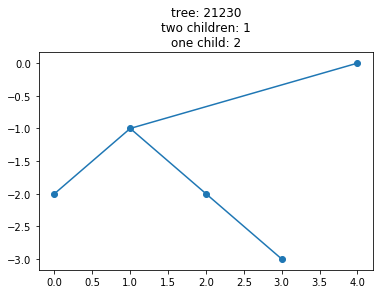

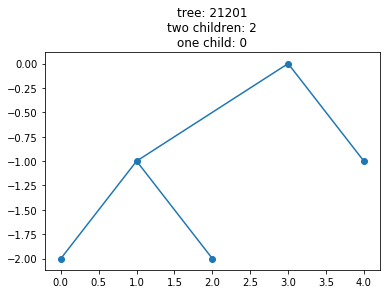

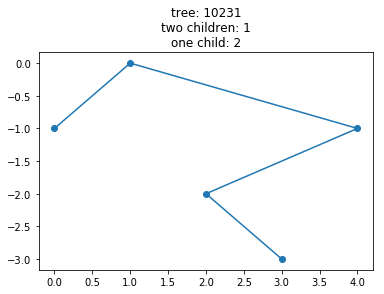

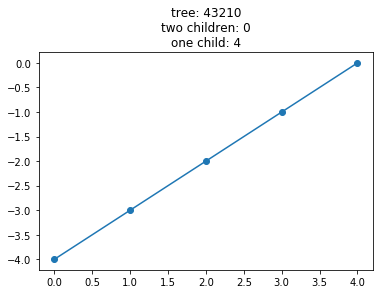

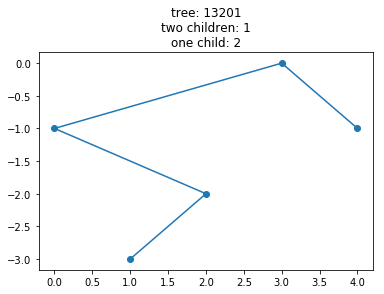

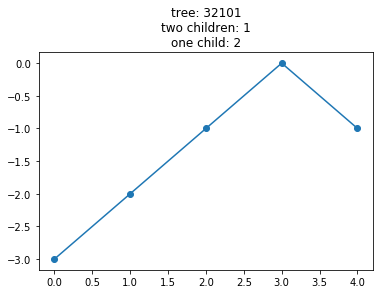

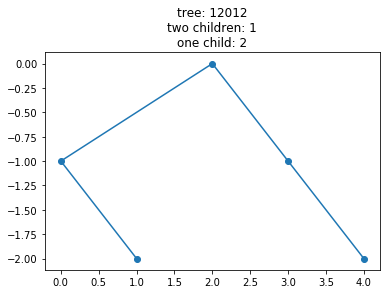

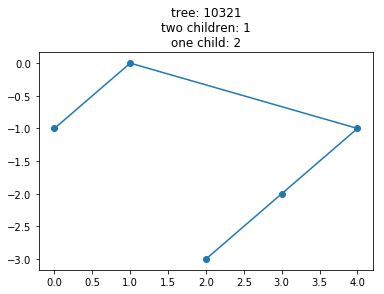

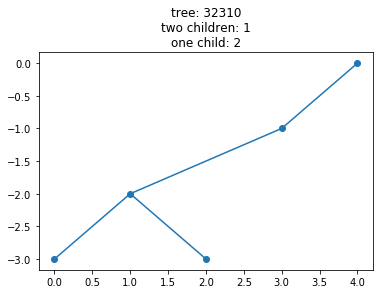

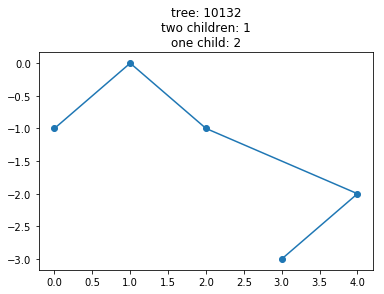

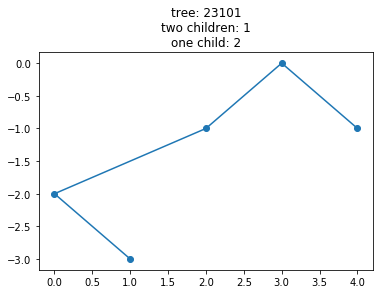

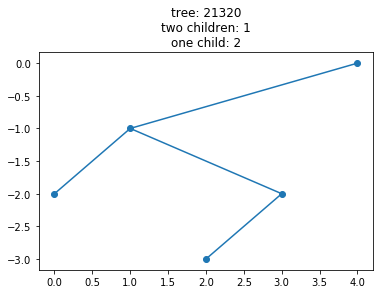

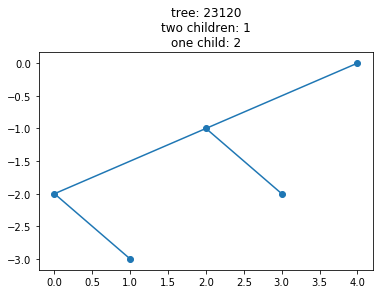

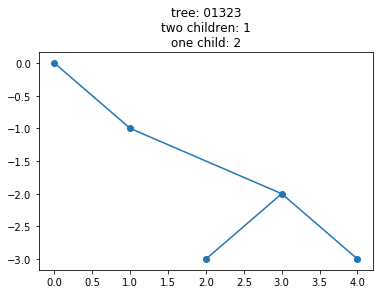

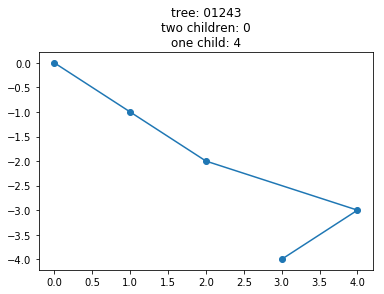

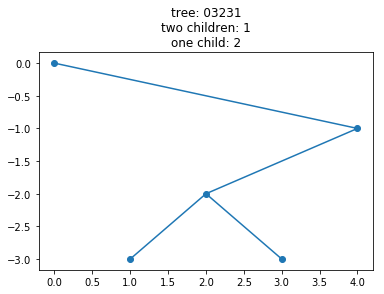

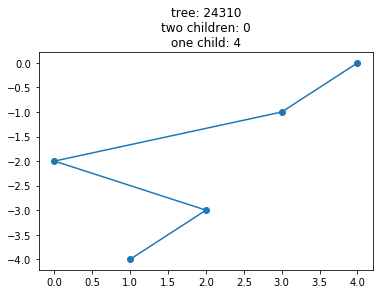

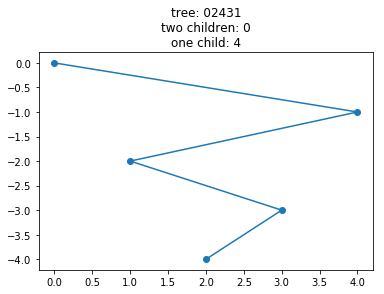

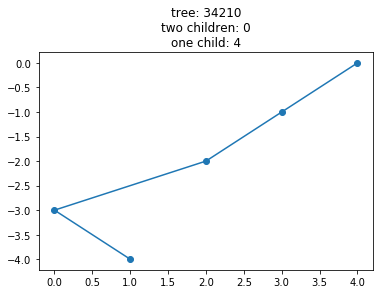

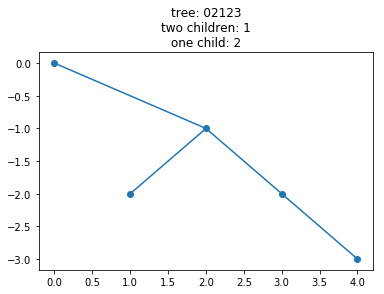

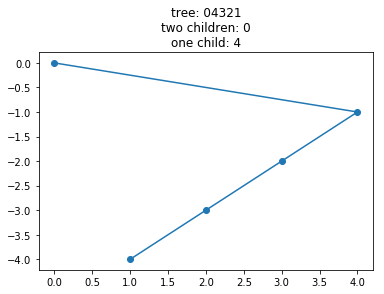

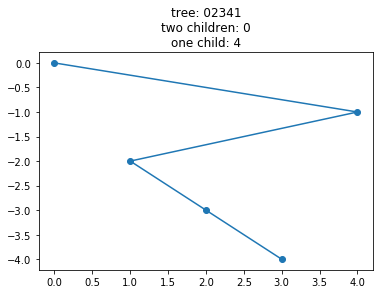

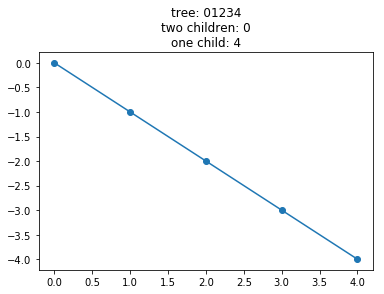

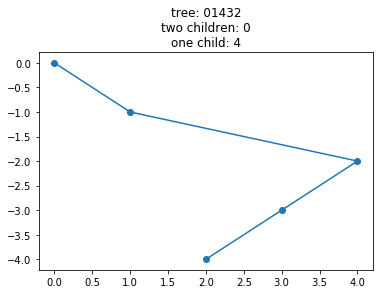

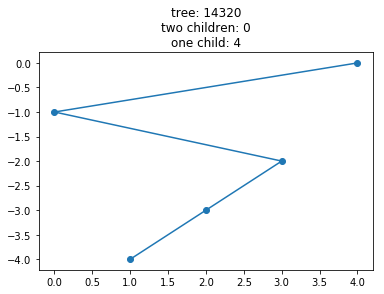

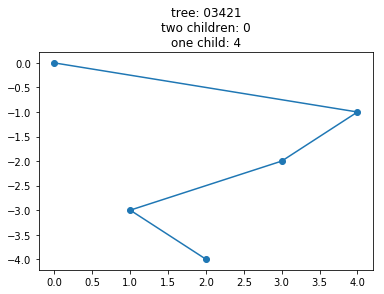

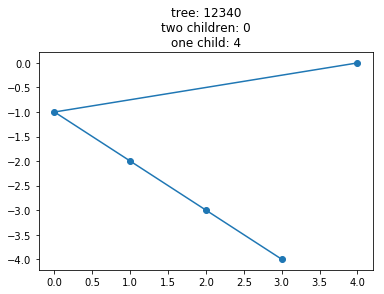

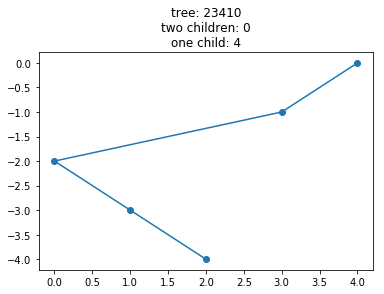

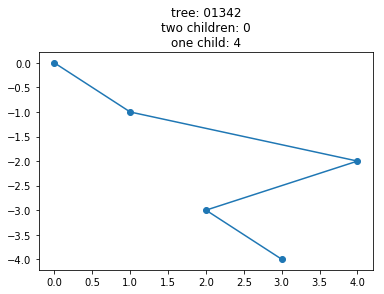

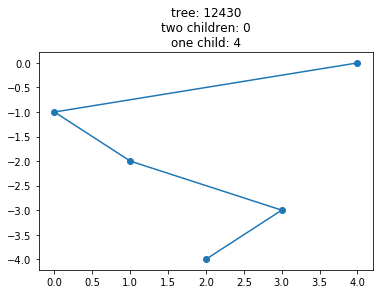

In [1481]:
for i, (k, v) in enumerate(short_five_dict.items()):
    plt.figure()
    viz_tree(inorder_viz_points(v))
    plt.title("tree: {}\ntwo children: {}\none child: {}".format(
                    k,
                    five_count_2s[k],
                    five_count_1s[k],
                )
             )


In [1479]:
five_count_2s = {k: count_2(v) for k,v in short_five_dict.items()}
five_count_2s

{'21021': 1,
 '12301': 1,
 '02132': 1,
 '10212': 2,
 '12021': 1,
 '02312': 1,
 '13230': 1,
 '03212': 1,
 '10123': 1,
 '32120': 1,
 '13420': 0,
 '21012': 1,
 '21230': 1,
 '21201': 2,
 '10231': 1,
 '43210': 0,
 '13201': 1,
 '32101': 1,
 '12012': 1,
 '10321': 1,
 '32310': 1,
 '10132': 1,
 '23101': 1,
 '21320': 1,
 '23120': 1,
 '01323': 1,
 '01243': 0,
 '03231': 1,
 '24310': 0,
 '02431': 0,
 '34210': 0,
 '02123': 1,
 '04321': 0,
 '02341': 0,
 '01234': 0,
 '01432': 0,
 '14320': 0,
 '03421': 0,
 '12340': 0,
 '23410': 0,
 '01342': 0,
 '12430': 0}

In [1462]:
[v for _, v in _.items()]

[1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [1463]:
sum(_)

28

In [1480]:
five_count_1s = {k: count_1(v) for k,v in short_five_dict.items()}
five_count_1s

{'21021': 2,
 '12301': 2,
 '02132': 2,
 '10212': 0,
 '12021': 2,
 '02312': 2,
 '13230': 2,
 '03212': 2,
 '10123': 2,
 '32120': 2,
 '13420': 4,
 '21012': 2,
 '21230': 2,
 '21201': 0,
 '10231': 2,
 '43210': 4,
 '13201': 2,
 '32101': 2,
 '12012': 2,
 '10321': 2,
 '32310': 2,
 '10132': 2,
 '23101': 2,
 '21320': 2,
 '23120': 2,
 '01323': 2,
 '01243': 4,
 '03231': 2,
 '24310': 4,
 '02431': 4,
 '34210': 4,
 '02123': 2,
 '04321': 4,
 '02341': 4,
 '01234': 4,
 '01432': 4,
 '14320': 4,
 '03421': 4,
 '12340': 4,
 '23410': 4,
 '01342': 4,
 '12430': 4}

In [1478]:
sum([v for k, v in _.items()])

112

## Derivation for Permutations

The asymptotics are slightly easier to derive for the permutations case (because, actually, the results are actually exact). The derivations are very similar to the case for leaves, but let's do it fully for practice. Consider the two functions $i(p)$ for the total number of nodes that have two interior children resulting from inserting a permutation $p$ into the tree, and $e(p)$ for exactly one interior child. We form, as usual:

$$
I(z) = \sum_{p \in P} i(p) \frac{z^{|p|}}{|p|!} = \sum_{n \geq 0} \sum_{p \in S_n} i(p) \frac{z^n}{n!}
$$

$$
E(z) = \sum_{p \in P} e(p) \frac{z^{|p|}}{|p|!} = \sum_{n \geq 0} \sum_{p \in S_n} e(p) \frac{z^n}{n!}.
$$

$E(z)$ is the slightly more interesting and complicated one: we do our now standard technique of breaking into root, left, and right subtrees. The complication comes in figuring out how to count the root. The root counts if and only if either the left or right subtree is empty, but _not_ if they're both empty. This is what accounts for the various Iverson brackets in the sum: $[k=0]$ corresponds to left empty subtree and $[k=n-1]$ corresponds to right empty subtree, and their product corresponds to both being empty. We subtract twice the product, as this is a trick to get the exclusive or.

$$
E(z) = \sum_{n \geq 2} \frac{1}{n!} \left(\sum_{k=0}^{n-1} {n-1 \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-1-k}}} (e(p_L) + e(p_R) + [k=0] + [k=n-1] - 2[k=0][k=n-1])\right)z^n.
$$

Our standard trick to make the power of $z$ and the $n-1$'s to match, is to take the derivative, and also shift the index on $n$ forward:

$$
E'(z) = \sum_{n \geq 1} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} (e(p_L) + e(p_R) + [k=0] + [k=n] - 2[k=0][k=n])\right)z^n.
$$

The summations involving $e_{t_L}$ and $e_{t_R}$ simplify exactly like the leaf calculation, and symmetry in the binomial coefficients allow us to only have to consider twice $t_L$:

$$
 \sum_{n \geq 1} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} (e(p_L) + e(p_R))\right)z^n = \sum_{n \geq 1} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} 2e(p_L) \right)z^n = \sum_{n \geq 1} \frac{1}{n!}\sum_{k=0}^n {n \choose k} \left(\sum_{p_L \in S_k} e(p_L) \right)\left(\sum_{p_R \in S_{n-k}} 2 \right)z^n
$$

This term is exactly what we computed before for leaves, and we recognize the product of EGFs:

$$
\sum_{n \geq 1} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} (e(p_L) + e(p_R))\right)z^n = \frac{2E(z)}{1-z}.
$$

Now let's look at the bracket terms. This is nice because the brackets get rid of some summations. Also the only time where $[k=0][k=n]$ is not zero is if $n=0$, and that's already known to be zero (it isn't even included in the sum on $n$):

$$
\sum_{n \geq 1} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} ([k=0] + [k=n] - 2[k=0][k=n])\right)z^n = \sum_{n \geq 1} \frac{1}{n!} \left({n \choose 0} \sum_{\substack{p_L \in S_0 \\ p_R \in S_{n}}} 1 + {n \choose n} \sum_{\substack{p_L \in S_n \\ p_R \in S_0}} 1\right)z^n = \sum_{n\geq 1} \frac{2n!}{n!} z^n = \frac{2}{1-z} - 2.
$$

The last equality was just summing a geometric series, except the constant term since the sum is over $n \geq 1$. Thus in total,

$$
E'(z) = \frac{2E(z)}{1-z} + \frac{2}{1-z} - 2.
$$

Rewriting it into integrating factor form,

$$
E'(z) - \frac{2E(z)}{1-z} = \frac{2}{1-z} - 2.
$$

We use the same integrating factor $\exp\left(-\int\frac{2}{1-z}\;dz\right) = (1-z)^2$:

$$
((1-z)^2 E)'(z) = 2(1-z) - 2(1-z)^2
$$

$$
(1-z)^2 E(z) = -(1-z)^2 + \frac{2}{3}(1-z)^3 + D
$$

where $D$ is a constant, so finally,

$$
E(z) = -1 + \frac{2}{3}(1-z) + \frac{D}{(1-z)^2}.
$$

The constant term $E(0)$ is $0$, so this can be used, as before, to solve for $D$: $E(0) = -1 + \frac{2}{3} + D$, or $D = \frac{1}{3}$. Thus,

$$
E(z) = -1 + \frac{2}{3}(1-z) + \frac{1}{3}\frac{1}{(1-z)^2}.
$$

Examining what this is as a series, we get

$$
E(z) = -1 + \frac{2}{3} - \frac{2}{3} z + \left(\frac{1}{3} + \frac{2}{3} z+ \frac{3}{3} z^2 + \frac{4}{3} z^3 + \cdots\right).
$$

This means, in particular, that the coefficient is $\frac{n+1}{3}$ for $n \geq 2$ and $0$ otherwise. Since the average is given by the coefficient times $n!$, divided by the number of permutations, also $n!$, the coefficients, as before, give exactly the average number of nodes with one child. Thus the answer is $\frac{n+1}{3}$. This is exactly the same as the average number of leaves! Plugging this into our examples confirms this.

To compute the two interior nodes, since the leaves, one-child, and two-children nodes are all disjoint and account for all nodes, tne number of two-child nodes must be $n - \frac{n+1}{3} + \frac{n+1}{3} = \frac{n-2}{3}$. But nevertheless it is instructive to try to compute it with EGFs anyway. The same decomposition and presence of terms $i(p_L) + i(p_R)$ is exactly the same (except that the sum is over $n \geq 2$), because the first nonzero occurrence is when the number of nodes is $3$. This means

$$
I'(z) = \frac{2 I(z)}{1-z} + \text{ some Iverson bracket terms}.
$$

We need to decide when to count a root. This happens exactly when both of the subtrees are nonempty, or $[k > 0][n-k > 0] = 1 - [k = 0] - [n-k=0])$. (They both never occur together since the term $n=0$ is eliminated. In all, this sum should be

$$
I'(z) = \frac{2 I(z)}{1-z} + \sum_{n \geq 2} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} (1-[k=0] - [k=n])\right)z^n.
$$

The thing one has to be very careful about here is where sums start. To take care of the $1$ in that sum, extend it to sum $n$ from zero and manually subtract off the terms when $n=0$ and $n=1$. Then we just note that the coefficients are the convolution of the EGF of permutations with itself, i.e. it's the square of the EGF for permutations, $\frac{1}{(1-z)^2}$. In equations, this is

$$
\sum_{n \geq 2} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k} \sum_{\substack{p_L \in S_k \\ p_R \in S_{n-k}}} 1\right) z^n = \sum_{n \geq 2} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k}k!(n-k)!\right) z^n = \sum_{n \geq 0} \frac{1}{n!} \left(\sum_{k=0}^{n} {n \choose k}k!(n-k)!\right) z^n - 1 - 2z = \frac{1}{(1-z)^2} - 1 - 2z.
$$

Finally, the bracket terms which do the same thing as they do in the case for $E(z)$:

$$
-\sum_{n \geq 2} \frac{1}{n!} \left({n \choose 0} \sum_{\substack{p_L \in S_0 \\ p_R \in S_{n}}} 1 + {n \choose n} \sum_{\substack{p_L \in S_n \\ p_R \in S_0}} 1\right)z^n = -\sum_{n \geq 2}\frac{2n!}{n!} z^n = -\frac{2}{1-z} + 2 + 2z.
$$

In all, we have

$$
I'(z) =  \frac{2 I(z)}{1-z} + \frac{1}{(1-z)^2} - 1 - 2z - \frac{2}{1-z} + 2 + 2z = \frac{2 I(z)}{1-z} + \frac{1}{(1-z)^2} - \frac{2}{1-z} + 1 
$$

The last term actually simplifies to $((1-z)^{-1} - 1)^2$, but this doesn't help us solve it, so we won't bother. Using the same integrating factor $(1-z)^2$ (since the factor multiplying $I(z)$ is still the same as before),

$$
((1-z)^2 I)'(z) = 1 - 2(1-z) + (1-z)^2
$$
$$
(1-z)^2 I(z) = z + (1-z)^2 - \frac{1}{3} (1-z)^3 + D
$$

and finally

$$
I(z) = \frac{z}{(1-z)^2} + 1 - \frac{1}{3}(1-z) + \frac{D}{(1-z)^2}.
$$

Plugging in $I(0) = 0$, we have $1 - \frac{1}{3} + D = 0$, or $D = -\frac{2}{3}$. Expanding out,

$$
I(z) = z + 2z^2 + 3z^3 + 4z^4 + 5z^5 + \cdots + 1 - \frac{1}{3} + \frac{1}{3} z - \frac{2}{3} - \frac{4}{3}z - \frac{6}{3}z^2 - \frac{8}{3}z^3 - \frac{10}{3} z^4 - \cdots
$$
The first three terms cancel, leaving us

$$
I(z) = \left(3-\frac{8}{3}\right)z^3 + \left(4 - \frac{10}{3}\right)z^4 + \left( 5 - \frac{12}{3} \right)z^5 + \left(6 - \frac{14}{3}\right)z^6 + \cdots = \frac{1}{3}z^3 + \frac{2}{3}z^4 + \frac{3}{3} z^5 + \frac{4}{3} z^6 + \cdots.
$$

One plainly sees here that the coefficient is $\frac{n-2}{3}$.

# From Permutations to the Catalan Distribution

We end on a note about computing a pdf on permutations that will give the Catalan distribution, so that we can also compute Catalan statistics by simulation. We have the transformation $\tau(p)$ which generates the tree with permutation $p$. We have that standard counting measure $\mu_N(t) = 1$ for each $t \in T_N$, and the permutation counting gives $\nu_N(t) = |\tau^{-1}(t)| = {N - 1 \choose |t_L|}|\tau^{-1}(t_L)||\tau^{-1}(t_R)|$ which is hard to give in closed form (but fairly easy to compute for a particular tree). Now we want the inverse, namely, a measure on permutations: $\mu_N(p) = \frac{1}{N!}$. Basically, what we want is $\nu_N(p)$ to be $\frac{1}{mc_n}$ where $m$ is the number of permutations that achieve the same tree $\tau(p)$ as $p$. I.e. $\nu_N(p) = \frac{1}{|\tau^{-1}(p)| c_n}$. A careful analysis of the case $N=4$ yields that, one should pick more extreme values for the root node; it turns out $5/14$ is best for $0$ and $3$, and $2/14$ is best for $1$ and $2$. Once $1$ and $2$ are picked, the permutation of the remaining is easy. But if $0$ or $3$ is picked, one of the remaining trees also has an uneven distribution, and _its_ extreme values should _also_ be greater.

In [1547]:
def catalan_4_random_perm():
    cdf = np.array([5, 7, 9, 14])/14
    first = np.searchsorted(cdf, np.random.rand())
    remainder = list(range(4))
    del remainder[first]
    if first == 1 or first == 2:
        return np.concatenate([[first], np.random.permutation(remainder)])
    else:
        cdf = np.array([2, 3, 5])/5
        second_i = np.searchsorted(cdf, np.random.rand())
        second = remainder[second_i]
        del remainder[second_i]
        return np.concatenate([[first, second], np.random.permutation(remainder)])
        

In [1548]:
perms = [catalan_4_random_perm() for _ in range(140000)]

In [1549]:
firsts = np.array(perms)[:, 0]

In [1550]:
firsts[:5]

array([3, 3, 0, 3, 0])

In [1551]:
catalan_4_random_perm()

array([0, 3, 1, 2])

Let's check that the first element (root node in the tree) is distributed according to $[5,2,2,5]/14$:

In [1552]:
np.count_nonzero(firsts == np.arange(4)[:, np.newaxis], axis=-1)

array([49936, 19881, 19922, 50261])

In [1555]:
catalan_4_random_perm()

array([0, 1, 3, 2])

We can now test the statistics by using the same dictionary-by-descriptor trick as we did before, to keep track of frequencies when simulating with a bunch of permutations.

In [1556]:
def test_catalan_stats(perms):
    freqs = collections.defaultdict(int)
    for i, p in enumerate(perms):
        if i % 1000 == 0:
            print("%d iterations" % i)
        t = Tree()
        t.mass_insert(*p)
        key = ''.join([str(i) for i in t.shape_descriptor()])
        freqs[key] += 1
    return freqs

In [1557]:
test_catalan_stats(perms)

0 iterations
1000 iterations
2000 iterations
3000 iterations
4000 iterations
5000 iterations
6000 iterations
7000 iterations
8000 iterations
9000 iterations
10000 iterations
11000 iterations
12000 iterations
13000 iterations
14000 iterations
15000 iterations
16000 iterations
17000 iterations
18000 iterations
19000 iterations
20000 iterations
21000 iterations
22000 iterations
23000 iterations
24000 iterations
25000 iterations
26000 iterations
27000 iterations
28000 iterations
29000 iterations
30000 iterations
31000 iterations
32000 iterations
33000 iterations
34000 iterations
35000 iterations
36000 iterations
37000 iterations
38000 iterations
39000 iterations
40000 iterations
41000 iterations
42000 iterations
43000 iterations
44000 iterations
45000 iterations
46000 iterations
47000 iterations
48000 iterations
49000 iterations
50000 iterations
51000 iterations
52000 iterations
53000 iterations
54000 iterations
55000 iterations
56000 iterations
57000 iterations
58000 iterations
59000 iter

defaultdict(<class 'int'>, {'1230': 10045, '0231': 10037, '0123': 10025, '0321': 10006, '1320': 10148, '3210': 9981, '2120': 10168, '2101': 9944, '1012': 10047, '1021': 9834, '1201': 9978, '0212': 9903, '0132': 9965, '2310': 9919})

It checks out!! All the descriptors are achieved about $10000$ times for the total of $140000$ trials!

In [1559]:
def cat(n):
    return binomial(2*n, n)// (n+1)

In [1561]:
cat(4)

14

Ok, now for the general algorithm. I did make one educated guess here that I haven't yet proved in detail, but this is the nature of experimentation. Basically, the idea is, one should make a recursive algorithm to get the random permutation. The reason why is because the tree's description is completely recursive. So given a random permutation $p$, its first element tells us what's going to be the root. Then the set of elements in the remaining array that are less than the root will go into the left subtree, and the set of elements greater than the root go into the right subtree. Both will do so as a contiguous block, BUT the repetition comes in precisely in allowing _shuffles_ of the two subtrees: letting their elements interleave (without changing the order within each subtree). So the key is to choose a random first element, which should have a higher probability of being an extreme value (to help remove the balancing bias). Then we should recursively compute a random permutation of the remaining nodes for the left and right, using the same algorithm to bias toward extreme values. This is because if the big tree has uniform weight, the subtrees had better have that as well.

To decide what weight to give them, it helps to recall the definition of the Catalan numbers: the next coefficient is the convolution of all the previous ones, because this reflects splitting and using the multiplication principle of counting on either side. Thus this means that a $k$-node left subtree (i.e. root value equal to $k$) should be selected with probability $c_k c_{n-1-k}/c_n$. The right subtree is completely determined by this as well. We can confirm this has more extreme values at the ends rather than at the center: you're multiplying by at least one large Catalan number. The square of the middle Catalan number is the smallest in the product, as well.

Now given the permutations corresponding to the left and right subtrees (with an extra operation to transfer the indices $0$ to $n-2-k$ to the indices $k+1$ to $n-1$ for the right ones), we need to shuffle them, which we do with equal probability for each such shuffle. How do we shuffle? We want to select $k$ positions out of $1$ to $n-1$ (position $0$ gets the root). This we can do by finding a permutation of the indices $1$ through $n-1$, and considering the first $k$ indices. It's $k$ indices that range from $1$ to $n-1$. One more important thing (and this is what defines what a _shuffle_ is): we also have to _sort_ those $k$ indices in increasing order, and place the permutation in that preserved order (that will ensure the same shape of tree is formed!). Similarly, for the right subree, sort the remaining $n-1-k$ indices in increasing order and place the right subtree's indices in those spots. `numpy` makes short work of this: simply use the sorted segment of shuffle _as_ the index as the target of the assigment of the permutation.

In [1664]:
def rand_perm_catalan(n):
    # Base cases: empty returns empty, and singular returns only zero.
    if n == 0:
        return np.array([], dtype=int)
    if n == 1:
        return np.array([0])
    # each bin should have size corresponding to the product of Catalan numbers
    pdf = np.array([cat(j)*cat(n-1-j) for j in range(n)])/cat(int(n))
    # The cumulative sum gives subintervals of which a random number is to land. (The CDF)
    cdf = np.cumsum(pdf)
    the_random = np.random.rand()
    # np.searchsorted will find the bin in which the random number generated belongs. Since the bins
    # corresponding to extreme values are wider, they will be selected with greater probability.
    k = int(np.searchsorted(cdf, the_random))
    assert k < n, "k must be less than n; cdf is {}\nrandom is {}".format(cdf, the_random)
    
    # set up the destination of the permutation
    perm = np.zeros((n,), dtype=int)
    
    # recursively get the left subtree by random permutation
    left_values = rand_perm_catalan(k)
    
    # recursively get the right subtree by random permutation. This has some slight additional gymnastics
    # to translate from indices of 0 through n-2-k to k+1 up to n-1.
    right_values_src = np.arange(k+1, n)
    right_values_inds = rand_perm_catalan(n - 1 - k)
    right_values = right_values_src[right_values_inds]
    
    # Now compute the shuffle as another permutation
    shuffle = np.random.permutation(range(1, n))
    
    # root is k
    perm[0] = k
    
    # sort the first k elements of the shuffle; install the left values into those spots IN THE SAME ORDER
    perm[sorted(shuffle[:k])] = left_values
    # sort the last n-k-1 elements of the shuffle; install the right values into those spots IN THE SAME ORDER
    perm[sorted(shuffle[k:])] = right_values
    
    return perm

I have to say, that is really an elegant algorithm. More elegant than I was expecting.

In [1650]:
rand_perm_catalan(4)

array([3, 0, 2, 1])

In [1651]:
binomial(3, 2)

3

In [1652]:
rand_perm_catalan(32)

array([30, 29, 12,  0, 14, 28,  9, 15, 16,  8, 20,  5, 17, 13,  1, 18, 24,
        4, 23, 11,  3, 19, 21,  6, 31, 22, 10,  2, 27, 26, 25,  7])

Bring out the big guns. A big big permutation. It takes some time to do, but not a lot.

In [1653]:
rand_perm_catalan(400)

array([399, 385, 384, 383,   0, 374, 342, 340, 361, 338, 337,   1,   3,
       336,  15,  18, 335,  19, 303, 302, 284,  21, 280,  24, 279, 387,
        25, 278, 277, 343,   6,  14,  26,  27,  35, 275, 274,   4, 282,
       273,  34,  36,  38, 124, 125,  13,  68, 375,  11, 373, 398,   7,
       269, 128, 299, 397, 327, 129, 268, 388, 267, 264, 109, 130, 260,
        77, 259,  39, 323, 131, 262, 358,  43, 286, 137,  33, 287, 257,
       238,  44, 104,  78, 276, 288,  47, 235, 138, 389, 392, 234, 239,
        48, 298, 139, 304, 365, 106, 256, 233, 248, 232,  79, 229, 344,
       247,  75, 140,  49,  51, 285, 272, 372, 173, 270, 386, 324,  10,
       148, 263, 175,  52, 167, 228, 177, 371,  53, 123,  76, 147, 252,
        81, 396, 127,  93, 110,  82,  83,  92,  40, 179,   9, 334, 221,
       166,  85, 168, 132, 222, 246, 220,  12, 217,  46, 356, 122, 240,
        91,  74,  37, 300, 216, 241, 172, 196,  88,  96, 223, 160, 155,
       143, 154, 321, 180, 195,  89, 249, 332, 245, 251, 394, 36

Finally, let's make sure it replicates our previous experiments, and gives a uniform distribution for, say, trees of $4$ nodes.

In [1656]:
perms = [rand_perm_catalan(4) for _ in range(14000)]

In [1657]:
test_catalan_stats(perms)

0 iterations
1000 iterations
2000 iterations
3000 iterations
4000 iterations
5000 iterations
6000 iterations
7000 iterations
8000 iterations
9000 iterations
10000 iterations
11000 iterations
12000 iterations
13000 iterations


defaultdict(<class 'int'>, {'2310': 1000, '0321': 1007, '2120': 1022, '0231': 970, '1230': 1023, '0132': 980, '1012': 1034, '0123': 983, '1201': 976, '3210': 991, '2101': 1017, '0212': 975, '1320': 1011, '1021': 1011})

# YESSS!!

Let's check $5$ nodes for good measure, to examine a case we didn't make a custom algorithm for.

In [1658]:
perms = [rand_perm_catalan(5) for _ in range(42000)]

In [1659]:
test_catalan_stats(perms)

0 iterations
1000 iterations
2000 iterations
3000 iterations
4000 iterations
5000 iterations
6000 iterations
7000 iterations
8000 iterations
9000 iterations
10000 iterations
11000 iterations
12000 iterations
13000 iterations
14000 iterations
15000 iterations
16000 iterations
17000 iterations
18000 iterations
19000 iterations
20000 iterations
21000 iterations
22000 iterations
23000 iterations
24000 iterations
25000 iterations
26000 iterations
27000 iterations
28000 iterations
29000 iterations
30000 iterations
31000 iterations
32000 iterations
33000 iterations
34000 iterations
35000 iterations
36000 iterations
37000 iterations
38000 iterations
39000 iterations
40000 iterations
41000 iterations


defaultdict(<class 'int'>, {'02341': 994, '34210': 1001, '03421': 999, '12340': 1071, '23410': 986, '32120': 1012, '02123': 992, '21021': 977, '32101': 994, '04321': 1002, '10132': 959, '10231': 912, '10321': 1025, '24310': 995, '21320': 1019, '02431': 1020, '21230': 1054, '03212': 1023, '02132': 1006, '12301': 1011, '01432': 996, '12430': 993, '01234': 971, '13230': 989, '03231': 977, '02312': 977, '12021': 1051, '21012': 990, '12012': 1011, '13420': 973, '01342': 996, '32310': 991, '23101': 1042, '13201': 1033, '01323': 969, '10123': 973, '01243': 979, '14320': 1010, '21201': 1007, '23120': 1013, '10212': 1001, '43210': 1006})

Excellent!!
# Visualizing Some Random Trees using the Catalan Distribution
Ok, let's finally get to what we've promised for a while. A visualization of typical trees from the Catalan distribution, rather than BSTs via permutations.

In [1660]:
def rand_tree_catalan(N):
    rtree = Tree()
    rtree.mass_insert(*rand_perm_catalan(N))
    return rtree

In [1662]:
bunch_of_uniform = [rand_tree_catalan(800) for _ in range(10)]

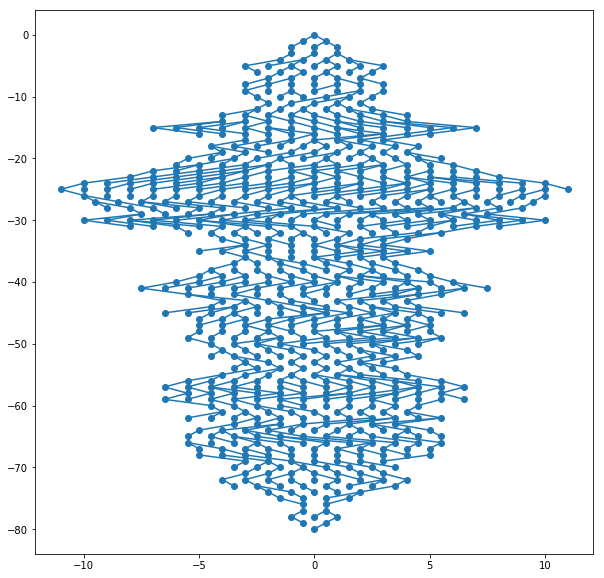

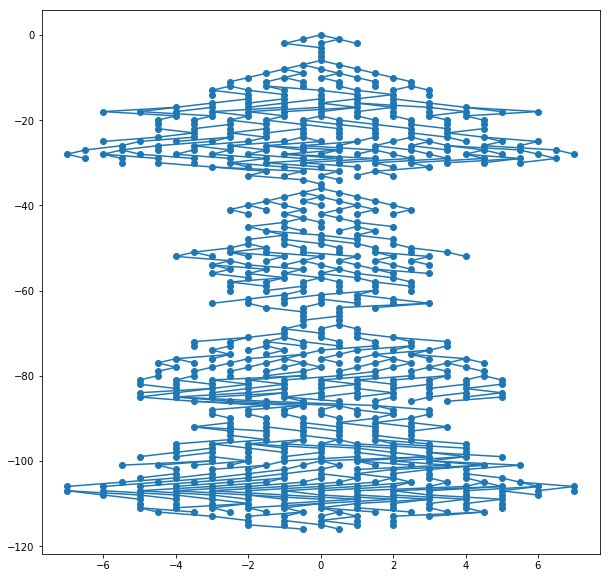

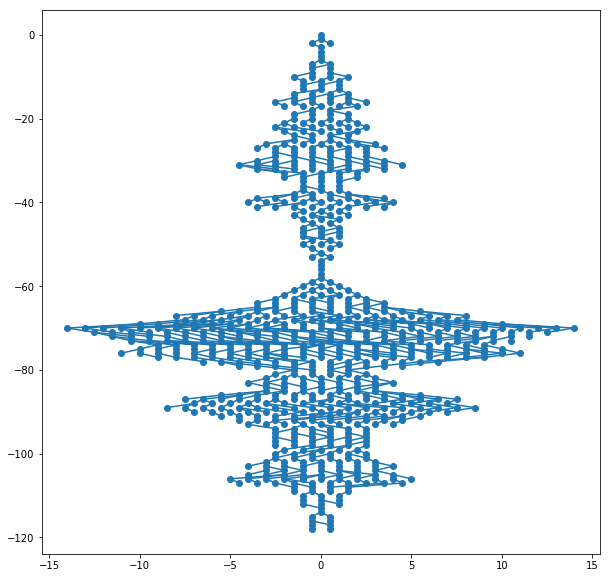

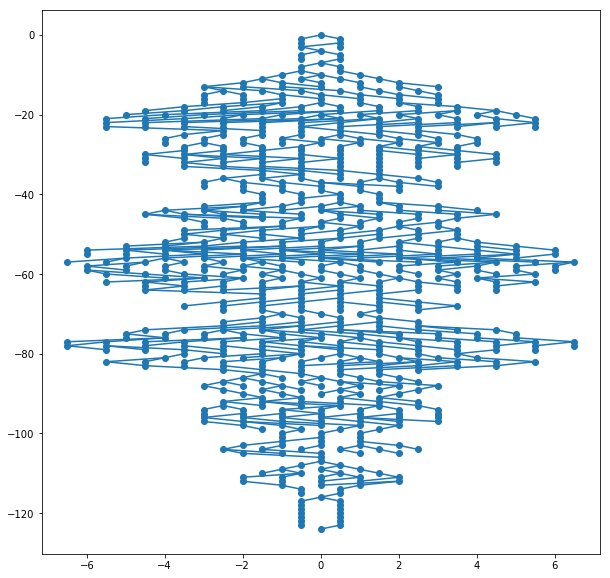

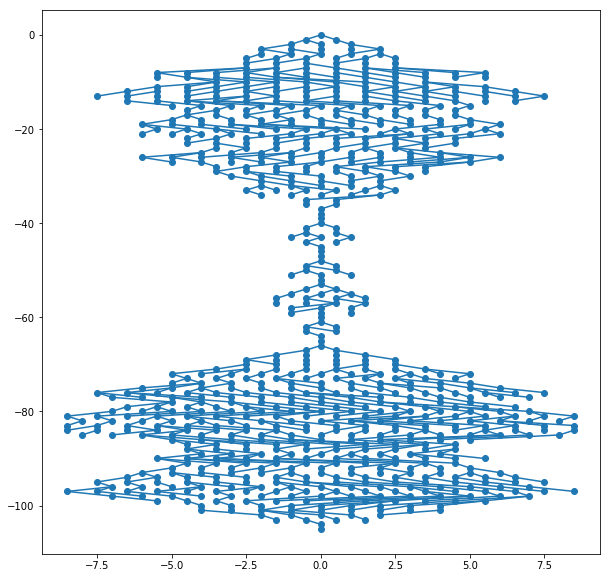

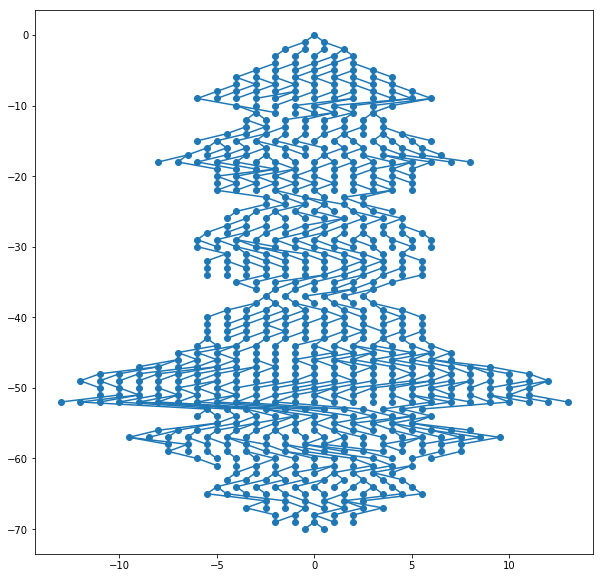

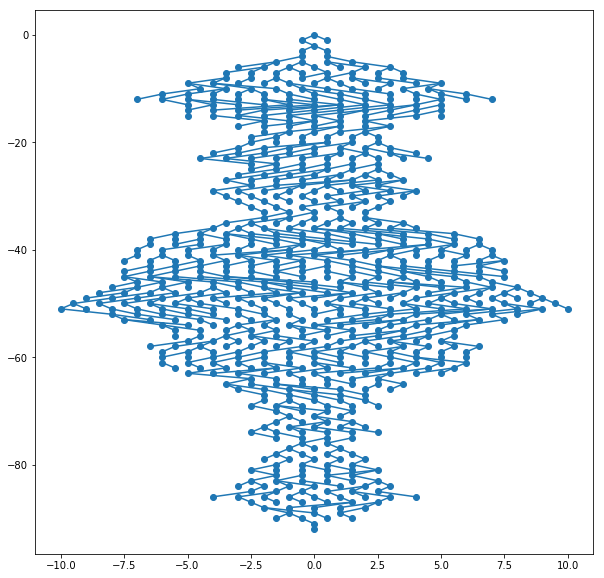

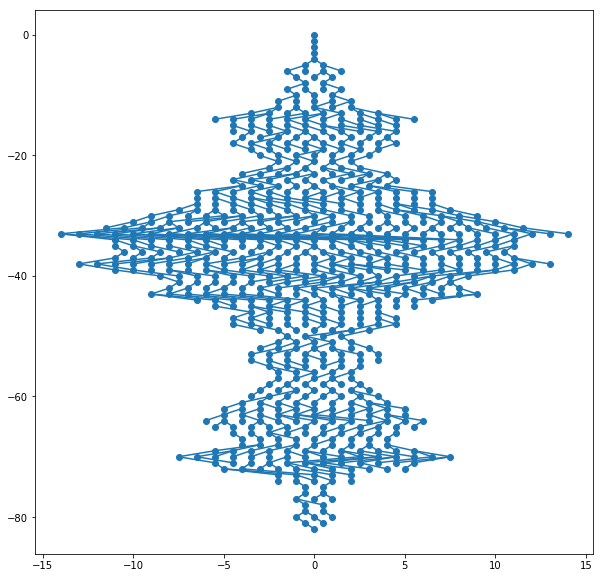

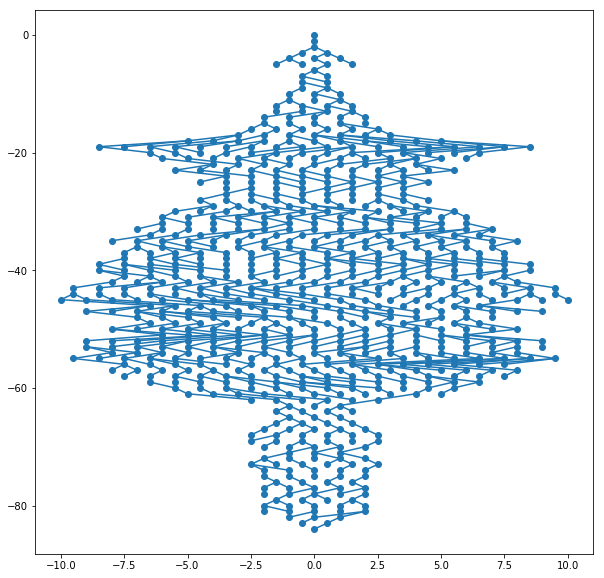

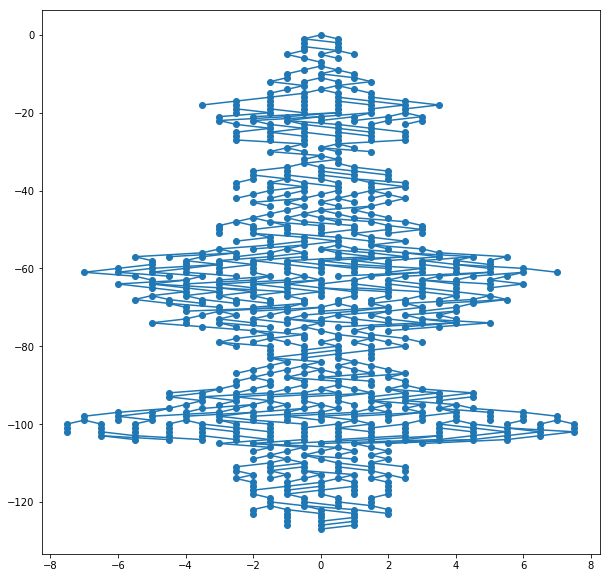

In [1663]:
for i in range(10):
    plt.figure(figsize=(10,10))
    viz_centered(inorder_viz_points(bunch_of_uniform[i]))

## That is profoundly different!
The trees look much more ragged and irregular, unlike the smooth, fat lanterns that are the mostly well-balanced BSTs. Let's look at a couple of examples of the inorder coordinate visualization as well:

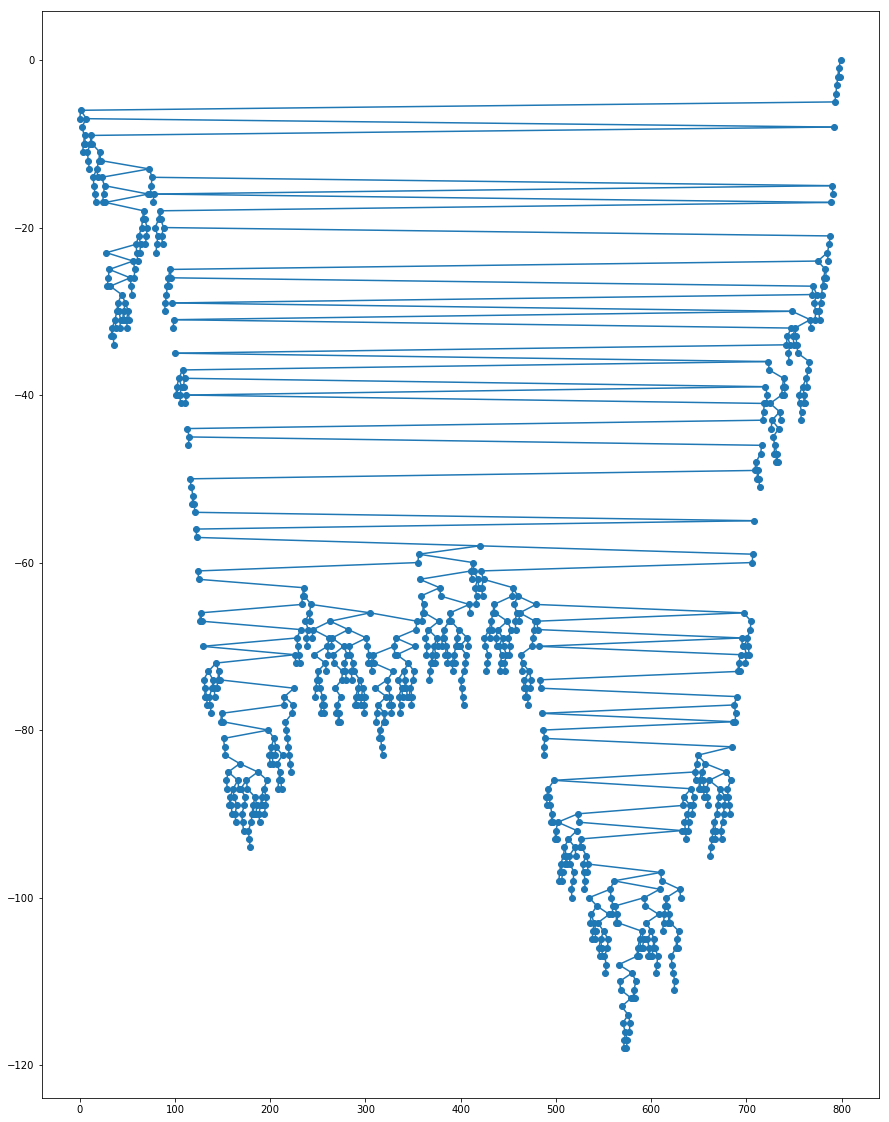

In [1679]:
plt.figure(figsize=(15,20))
viz_tree(inorder_viz_points(bunch_of_uniform[2]))

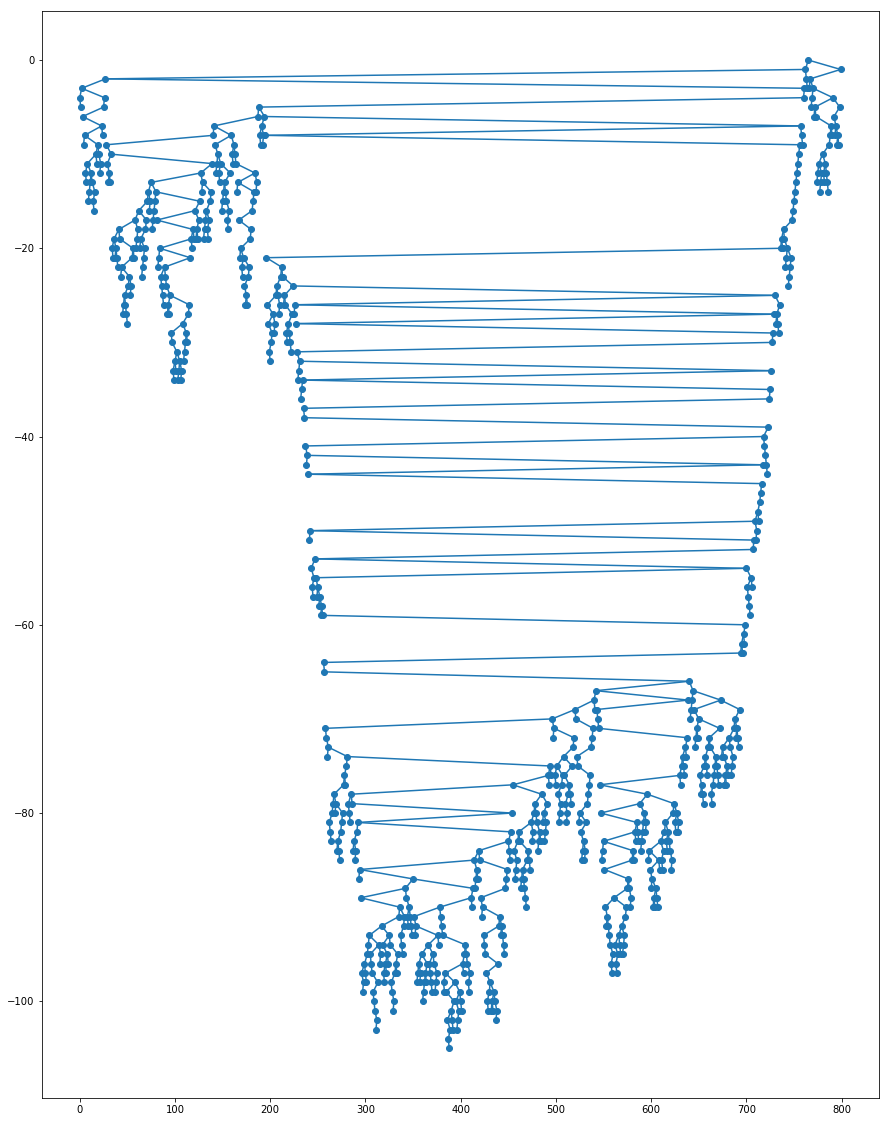

In [1678]:
plt.figure(figsize=(15,20))
viz_tree(inorder_viz_points(bunch_of_uniform[4]))

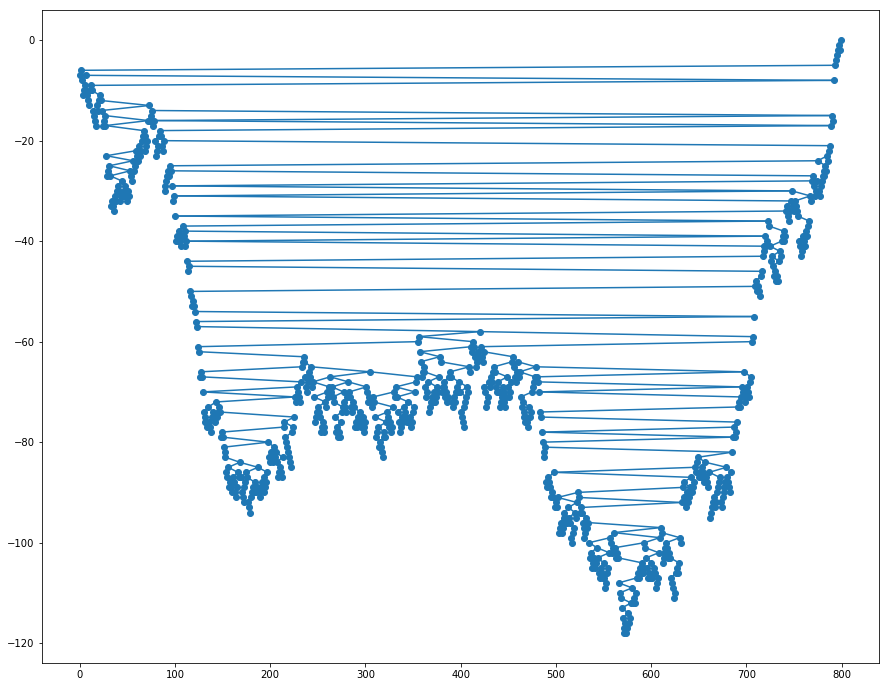

In [1683]:
plt.figure(figsize=(15,12))
viz_tree(inorder_viz_points(bunch_of_uniform[2]))

These look _completely_ different from the more-or-less intuitive balanced trees we obtained earlier. Would you like to harvest some nodes to make a wine?

In [1691]:
[(cat(n), (4**n/sqrt(pi*n**3)).n(60) ) for n in range(1, 100)]

[(1, 2.2567583341910251),
 (2, 3.1915382432114614),
 (5, 6.9490135026193056),
 (14, 18.054066673528201),
 (42, 51.673754050972878),
 (132, 157.23822624828779),
 (429, 499.11192107399597),
 (1430, 1634.0675805242682),
 (4862, 5477.7375625756676),
 (16796, 18707.897292190081),
 (58786, 64862.837060189673),
 (208012, 227705.27445382940),
 (742900, 807774.09695938795),
 (2674440, 2.8911650731005333e6),
 (9694845, 1.0427688397086901e7),
 (35357670, 3.7862122032523014e7),
 (129644790, 1.3828387286377236e8),
 (477638700, 5.0768712513061188e8),
 (1767263190, 1.8725546333212096e9),
 (6564120420, 6.9355338659523759e9),
 (24466267020, 2.5784335259885508e10),
 (91482563640, 9.6185775674639201e10),
 (343059613650, 3.5992590902061202e11),
 (1289904147324, 1.3506660788348897e12),
 (4861946401452, 5.0817679964639811e12),
 (18367353072152, 1.9165705752604400e13),
 (69533550916004, 7.2443459770807522e13),
 (263747951750360, 2.7438968039123787e14),
 (1002242216651368, 1.0412806914655981e15),
 (3814986502